In [1]:
import eurostat
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

code_renewables = 'nrg_inf_epcrw'  # Electricity production capacities for renewables and wastes
code_other = 'nrg_inf_epc'    # Electricity production capacities by main fuel groups and operator
code_pop = 'demo_pjangroup'

## Loading the data

In [2]:
def load_data(code):
    pars = eurostat.get_pars(code)

    descriptions = {}
    for par in pars:
        par_values = eurostat.get_par_values(code, par)
        dic = eurostat.get_dic(code, par)
        tempdict = {}
        for flag, description in dic:
            if(flag in par_values):
                tempdict[flag] = description
        descriptions[par] = tempdict
    
    data = eurostat.get_data(code)
    
    return data, descriptions

In [3]:
data_renewables, descriptions_renewables = load_data(code_renewables)
columns = list(data_renewables[0])
columns[4] = 'geo'
data_renewables = pd.DataFrame(data_renewables[1:], columns=columns)

In [4]:
data_other, descriptions_other = load_data(code_other)
columns = list(data_other[0])
columns[5] = 'geo'
data_other = pd.DataFrame(data_other[1:], columns=columns)

In [5]:
data_pop, descriptions_pop = load_data(code_pop)
columns = list(data_pop[0])
columns[4] = 'geo'
data_pop = pd.DataFrame(data_pop[1:], columns=columns)

In [6]:
all_countries = set(np.unique(data_other['geo'])) | set(np.unique(data_renewables['geo']))

In [7]:
countries_only_in_renewables = set(np.unique(data_renewables['geo'])) - set(np.unique(data_other['geo']))

In [8]:
COUNTRY = data_renewables['geo'] == None
plant_tec = data_renewables['plant_tec'] == 'CAP_NET_ELC'
for geo in all_countries:
    COUNTRY = np.logical_or(COUNTRY, data_renewables['geo'] == geo)

condition_renewables = np.logical_and(COUNTRY, plant_tec)

In [9]:
plant_tec =  data_other['plant_tec'] == 'CAP_NET_ELC'
OPERATOR = data_other['operator'] == 'PRR_MAIN'
in_RENEWABLES = data_other['siec'] == None
for siec in np.unique(data_renewables['siec']):
    in_RENEWABLES = np.logical_or(in_RENEWABLES, data_other['siec'] == siec)
    
COUNTRY = data_other['geo'] == None
for geo in all_countries:
    COUNTRY = np.logical_or(COUNTRY, data_other['geo'] == geo)

in_RENEWABLES = np.negative(in_RENEWABLES)

condition_other = np.logical_and(plant_tec, in_RENEWABLES)
condition_other = np.logical_and(condition_other, OPERATOR)
condition_other = np.logical_and(condition_other, COUNTRY)

a = data_other.drop('operator', axis=1).loc[condition_other].reset_index().drop('index', axis=1)
for geo in countries_only_in_renewables:
    for siec in np.unique(a.siec):
        vstavi = []
        for key in a:
            if key == 'siec':
                vstavi.append(siec)
            elif key == 'geo':
                vstavi.append(geo)
            else:
                vstavi.append(np.NaN)
        a.loc[len(a.index)] = vstavi 

data_combined = pd.concat(
    [a, data_renewables.loc[condition_renewables]]
    ).sort_values(by=['siec', 'geo']).reset_index().drop(['index','freq','plant_tec','unit'], axis=1)

In [64]:
a.tail()

AttributeError: 'numpy.ndarray' object has no attribute 'tail'

## Making a lookup function

In [11]:
what_is_descriptions = defaultdict(dict)
def what_is_data(descriptions={}, reset=False):
    if reset:
        global what_is_descriptions
        what_is_descriptions = defaultdict(dict)
        return
    for name in descriptions.keys():
        for tip, description in descriptions[name].items():
            what_is_descriptions[name][tip] = description

In [12]:
what_is_data(reset=True)
what_is_data(descriptions_other)
# what_is_data(descriptions_pop)
what_is_data(descriptions_renewables)
def what_is(descriptor, short=False):
    for name, description in what_is_descriptions.items():
        if descriptor in description:
            return f'type: {name} --> {descriptor}: {what_is_descriptions[name][descriptor]}' if not short else f'{what_is_descriptions[name][descriptor]}'
    return f'{descriptor} does not exsist'

## Imputing missing data from population

# TODO ugotov kako bujse imputirat

In [13]:
AGE = data_pop['age'] == 'TOTAL'
GENDER = data_pop['sex'] == 'T'
is_COUNTRY = data_pop['geo'] == None

for country in descriptions_renewables['geo'].keys():
    if country != 'EA20' and country != 'EU27_2020':
        is_COUNTRY = np.logical_or(is_COUNTRY, data_pop['geo'] == country)
condition = np.logical_and(AGE, GENDER)
condition = np.logical_and(condition, is_COUNTRY)
data_pop_all = data_pop.loc[condition]


data_pop_all = data_pop_all.drop(['freq','unit','age','sex'], axis=1)

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
imputer = KNNImputer(n_neighbors=2, weights="distance")
# imputer = IterativeImputer(max_iter=10, random_state=0)
# imputer = SimpleImputer(max_iter=10, random_state=0)
a = imputer.fit_transform(np.rot90(data_pop_all.drop(['geo'], axis=1), k=1))
neki = []
a = np.rot90(a, k=3)
for country, pop in zip(data_pop_all['geo'], a):
    neki.append(pop) 

neki = np.array(neki)
data_pop_imputed = {}

data_pop_imputed['geo'] = data_pop_all['geo']
for name, ind in zip(data_pop_all.columns[1:], range(0, len(data_pop_all.columns)-1)):
    data_pop_imputed[name] = neki[:, ind]
data_pop_imputed = pd.DataFrame(data_pop_imputed)

is_COUNTRY = data_pop_imputed['geo'] == 'XK'

# for country in {'BA', 'FR', 'GE', 'MD', 'ME', 'RS', 'UA', 'XK', 'UK'}:
#     is_COUNTRY = np.logical_or(is_COUNTRY, data_pop_imputed['geo'] == country)

for year in data_pop_imputed.keys()[1:]:
    if year not in data_combined.keys():
        data_pop_imputed = data_pop_imputed.drop(str(year), axis=1)

data_pop_imputed[is_COUNTRY]

geo          1990          1991          1992          1993  \
2572  XK  2.000322e+06  1.999806e+06  1.999709e+06  1.999587e+06   

              1994          1995          1996          1997          1998  \
2572  1.999449e+06  1.999275e+06  1.999039e+06  1.998735e+06  1.998388e+06   

      ...          2013          2014          2015       2016       2017  \
2572  ...  1.948402e+06  1.783113e+06  1.775939e+06  1771604.0  1783531.0   

           2018       2019       2020       2021       2022  
2572  1798506.0  1795666.0  1782115.0  1798186.0  1773971.0  

[1 rows x 34 columns]

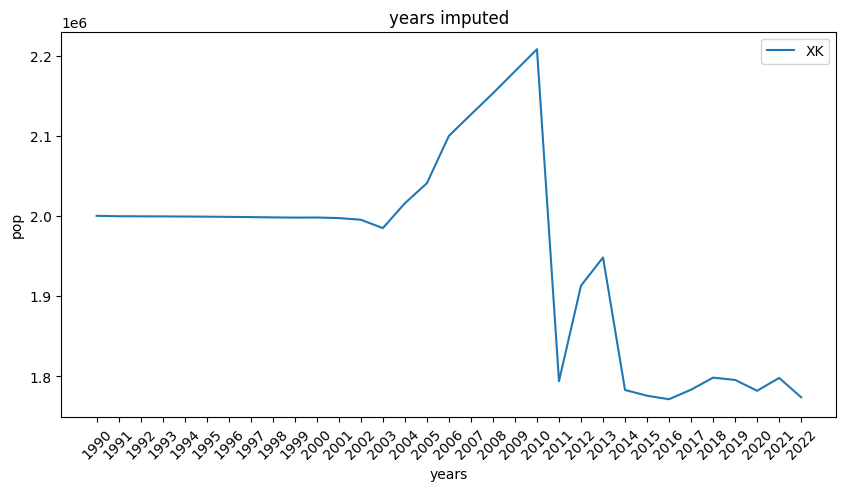

In [15]:
years = data_pop_imputed[is_COUNTRY].columns.tolist()[1:]

# vosta_energij_po_vrsti.plot(x='1990', y='1992')
# fig2 = {'R5100', 'X9900', 'RA500', 'RA200'}
#         CF         N9000      R5100    RA100      RA200    RA300     RA400      RA500    X9900
# colors= ['#232023', '#39FF14', 'green', '#007fff', 'cyan', '#787276', '#a91b0d', 'navy', '#FF00FF']

plt.figure(figsize=(10, 5))
for row in data_pop_imputed[is_COUNTRY].values:
    plt.plot(years, row[1:], label=row[0])

# plt.subplot(1, 2, 1)
plt.ylabel('pop')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('years imputed')
plt.legend();

In [16]:
what_is('RA120')

'type: siec --> RA120: Mixed hydro power'

In [17]:
pd.set_option('display.max_columns', 100) #default 20

In [18]:
not_in_energy = []
for geo in data_pop_all['geo']:
    if  what_is(geo)[-6:] == 'exsist':
        not_in_energy.append(geo)

In [19]:
for name in not_in_energy:
    data_pop_all = data_pop_all.drop(data_pop_all[data_pop_all['geo'] == name].index)

In [20]:
import numpy as np
is_PRODUCING = data_other['operator'] == 'PRR_MAIN'
is_SI = data_other['geo'] == 'DE'
is_ACTIVE =  data_other['plant_tec'] == 'CAP_NET_ELC'
condition = np.logical_and(is_PRODUCING, is_ACTIVE)
condition = np.logical_and(condition, is_SI)
data_other.loc[condition].drop([str(year) for year in range(1990, 2021)], axis=1).drop("2022", axis=1)

freq     siec    plant_tec  operator unit geo      2021
44      A       CF  CAP_NET_ELC  PRR_MAIN   MW  DE   88178.0
266     A    N9000  CAP_NET_ELC  PRR_MAIN   MW  DE    8113.0
488     A    RA100  CAP_NET_ELC  PRR_MAIN   MW  DE   10809.0
562     A    RA110  CAP_NET_ELC  PRR_MAIN   MW  DE    4321.0
784     A    RA120  CAP_NET_ELC  PRR_MAIN   MW  DE    1134.0
1006    A    RA130  CAP_NET_ELC  PRR_MAIN   MW  DE    5354.0
1228    A    RA200  CAP_NET_ELC  PRR_MAIN   MW  DE      46.0
1450    A    RA300  CAP_NET_ELC  PRR_MAIN   MW  DE   63711.0
1524    A    RA310  CAP_NET_ELC  PRR_MAIN   MW  DE       0.0
1746    A    RA320  CAP_NET_ELC  PRR_MAIN   MW  DE       0.0
1968    A    RA410  CAP_NET_ELC  PRR_MAIN   MW  DE       2.0
2190    A    RA420  CAP_NET_ELC  PRR_MAIN   MW  DE   60036.0
2264    A  RA420AC  CAP_NET_ELC  PRR_MAIN   MW  DE       0.0
2486    A  RA420DC  CAP_NET_ELC  PRR_MAIN   MW  DE   60036.0
2708    A    RA500  CAP_NET_ELC  PRR_MAIN   MW  DE       0.0
2930    A    TOTAL  CAP_NET_ELC  PRR_MAIN   MW  DE  231406.0
3004    A    X9900  CAP_NET_ELC  PRR_MAIN   MW  DE     511.0

In [21]:
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110','RA110ROR', 'RA120', 'RA130']}
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110', 'RA120', 'RA130']}
# data = eurostat.get_data(code, filter_pars=my_filter_pars)
# data[1:]

In [22]:
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110','RA110ROR', 'RA120', 'RA130']}
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110', 'RA120', 'RA130']}
# data = eurostat.get_data(code_renewables, filter_pars=my_filter_pars)

In [23]:
siec_not_to_include = {'RA110','RA120','RA130','RA310','RA320','RA410','RA420','RA420AC',
                       'RA420DC','R5210P','R5220P','R5290','R5300','RA110ROR','RA420KW20-1000',
                       'RA420KW30-1000','RA420KW30-1000_OG','RA420KW30-1000_RT','RA420KW_LT10',
                       'RA420KW_LT20','RA420KW_LT30','RA420KW_LT30_OG','RA420KW_LT30_RT','RA420MW_GT1',
                       'RA420MW_GT1_OG','RA420MW_GT1_RT','RA420OG','W6000','W6100','W6200','TOTAL'}

<!--- 1. Za vsak tip proizvodnje energije katera država najbolj proizvaja omenjeno energijo --->
1. Primerjava proizvodnje držav za vsak tip proizvodnje energije

In [79]:
YEAR = '2021' # change the year of the data for the map and the graph

In [85]:
data_combined.loc[data_combined.geo == 'IS']

siec geo   1990   1991   1992   1993   1994   1995   1996  \
20                CF  IS    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
63             N9000  IS    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
106            R5100  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
149           R5210P  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
192           R5220P  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
235            R5290  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
278            R5300  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
321            RA100  IS  756.0  779.0  879.0  879.0  884.0  884.0  884.0   
364            RA110  IS  756.0  779.0  879.0  879.0  884.0  884.0  884.0   
407         RA110ROR  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
450            RA120  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
493            RA130  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
536            RA200  IS   46.0   45.0   45.0   51.0   51.0   51.0   51.0   
579            RA300  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
622            RA310  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
665            RA320  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
708            RA400  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
751            RA410  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
794            RA420  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
837          RA420AC  IS    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
880          RA420DC  IS    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
918   RA420KW20-1000  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1117    RA420KW_LT20  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1280     RA420MW_GT1  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1400         RA420OG  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1443           RA500  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1486           TOTAL  IS    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1529           W6000  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1572           W6100  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1615           W6200  IS    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1658           X9900  IS    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

       1997   1998    1999    2000    2001    2002    2003    2004    2005  \
20      NaN    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
63      NaN    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
106     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
149     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
192     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
235     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
278     0.0    0.0     0.0     0.0     0.0     0.0     0.0     1.0     1.0   
321   923.0  956.0  1016.0  1064.0  1109.0  1155.0  1155.0  1163.0  1163.0   
364   923.0  956.0  1016.0  1064.0  1109.0  1155.0  1155.0  1163.0  1163.0   
407     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
450     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
493     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
536    80.0  140.0   172.0   172.0   202.0   202.0   202.0   202.0   232.0   
579     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
622     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
665     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
708     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
751     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
794     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0   

In [87]:
SIEC = data_combined['siec'] == None
for siec in siec_not_to_include:
    SIEC = np.logical_or(SIEC, data_combined['siec'] == siec)
SIEC = np.negative(SIEC)
GEO = np.logical_and(data_combined['geo'] != 'EA20', data_combined['geo'] != 'EU27_2020')
condition = np.logical_and(SIEC, GEO)

In [88]:
data_combined_YEAR = data_combined.loc[condition].drop([key for key in data_pop_imputed.keys() if key not in {'geo', YEAR}], axis=1).reset_index().drop('index', axis=1)

In [90]:
data_pop_YEAR = data_pop_imputed.drop([key for key in data_pop_imputed.keys() if key not in {'geo', YEAR}], axis=1)
GEO = data_pop_YEAR['geo'] == None
for country in np.unique(data_combined_YEAR['geo']):
    GEO = np.logical_or(GEO, data_pop_YEAR['geo'] == country)
data_pop_YEAR = data_pop_YEAR.loc[GEO].reset_index().drop('index', axis=1)

In [91]:
data_pop_YEAR_reshaped = pd.DataFrame(data_pop_YEAR[YEAR].to_numpy().reshape(1, len(data_pop_YEAR)))
data_pop_YEAR_temp = data_pop_YEAR_reshaped.reindex([YEAR], columns=np.unique(data_pop_YEAR['geo']))

In [92]:
for country, val in zip(data_pop_YEAR_temp.keys(), data_pop_YEAR_reshaped.keys()):
    data_pop_YEAR_temp[country] = list(data_pop_YEAR_reshaped[val])
data_pop_YEAR_reshaped = data_pop_YEAR_temp

In [93]:
data_combined_YEAR_reshaped = pd.DataFrame(data_combined_YEAR[YEAR].to_numpy().reshape(9, len(data_pop_YEAR)))
data_combined_YEAR_temp = data_combined_YEAR_reshaped.reindex(labels=np.unique(data_combined_YEAR['siec']), columns=np.unique(data_combined_YEAR['geo']))

In [94]:
for country, val in zip(data_combined_YEAR_temp.keys(), data_combined_YEAR_reshaped.keys()):
    data_combined_YEAR_temp[country] = list(data_combined_YEAR_reshaped[val])
data_combined_YEAR_reshaped = data_combined_YEAR_temp
for country in data_combined_YEAR_reshaped.keys():
    data = data_combined_YEAR_reshaped[country].values * 24 * 1000 / data_pop_YEAR_reshaped[country][0]
    data_combined_YEAR_reshaped[country] = data

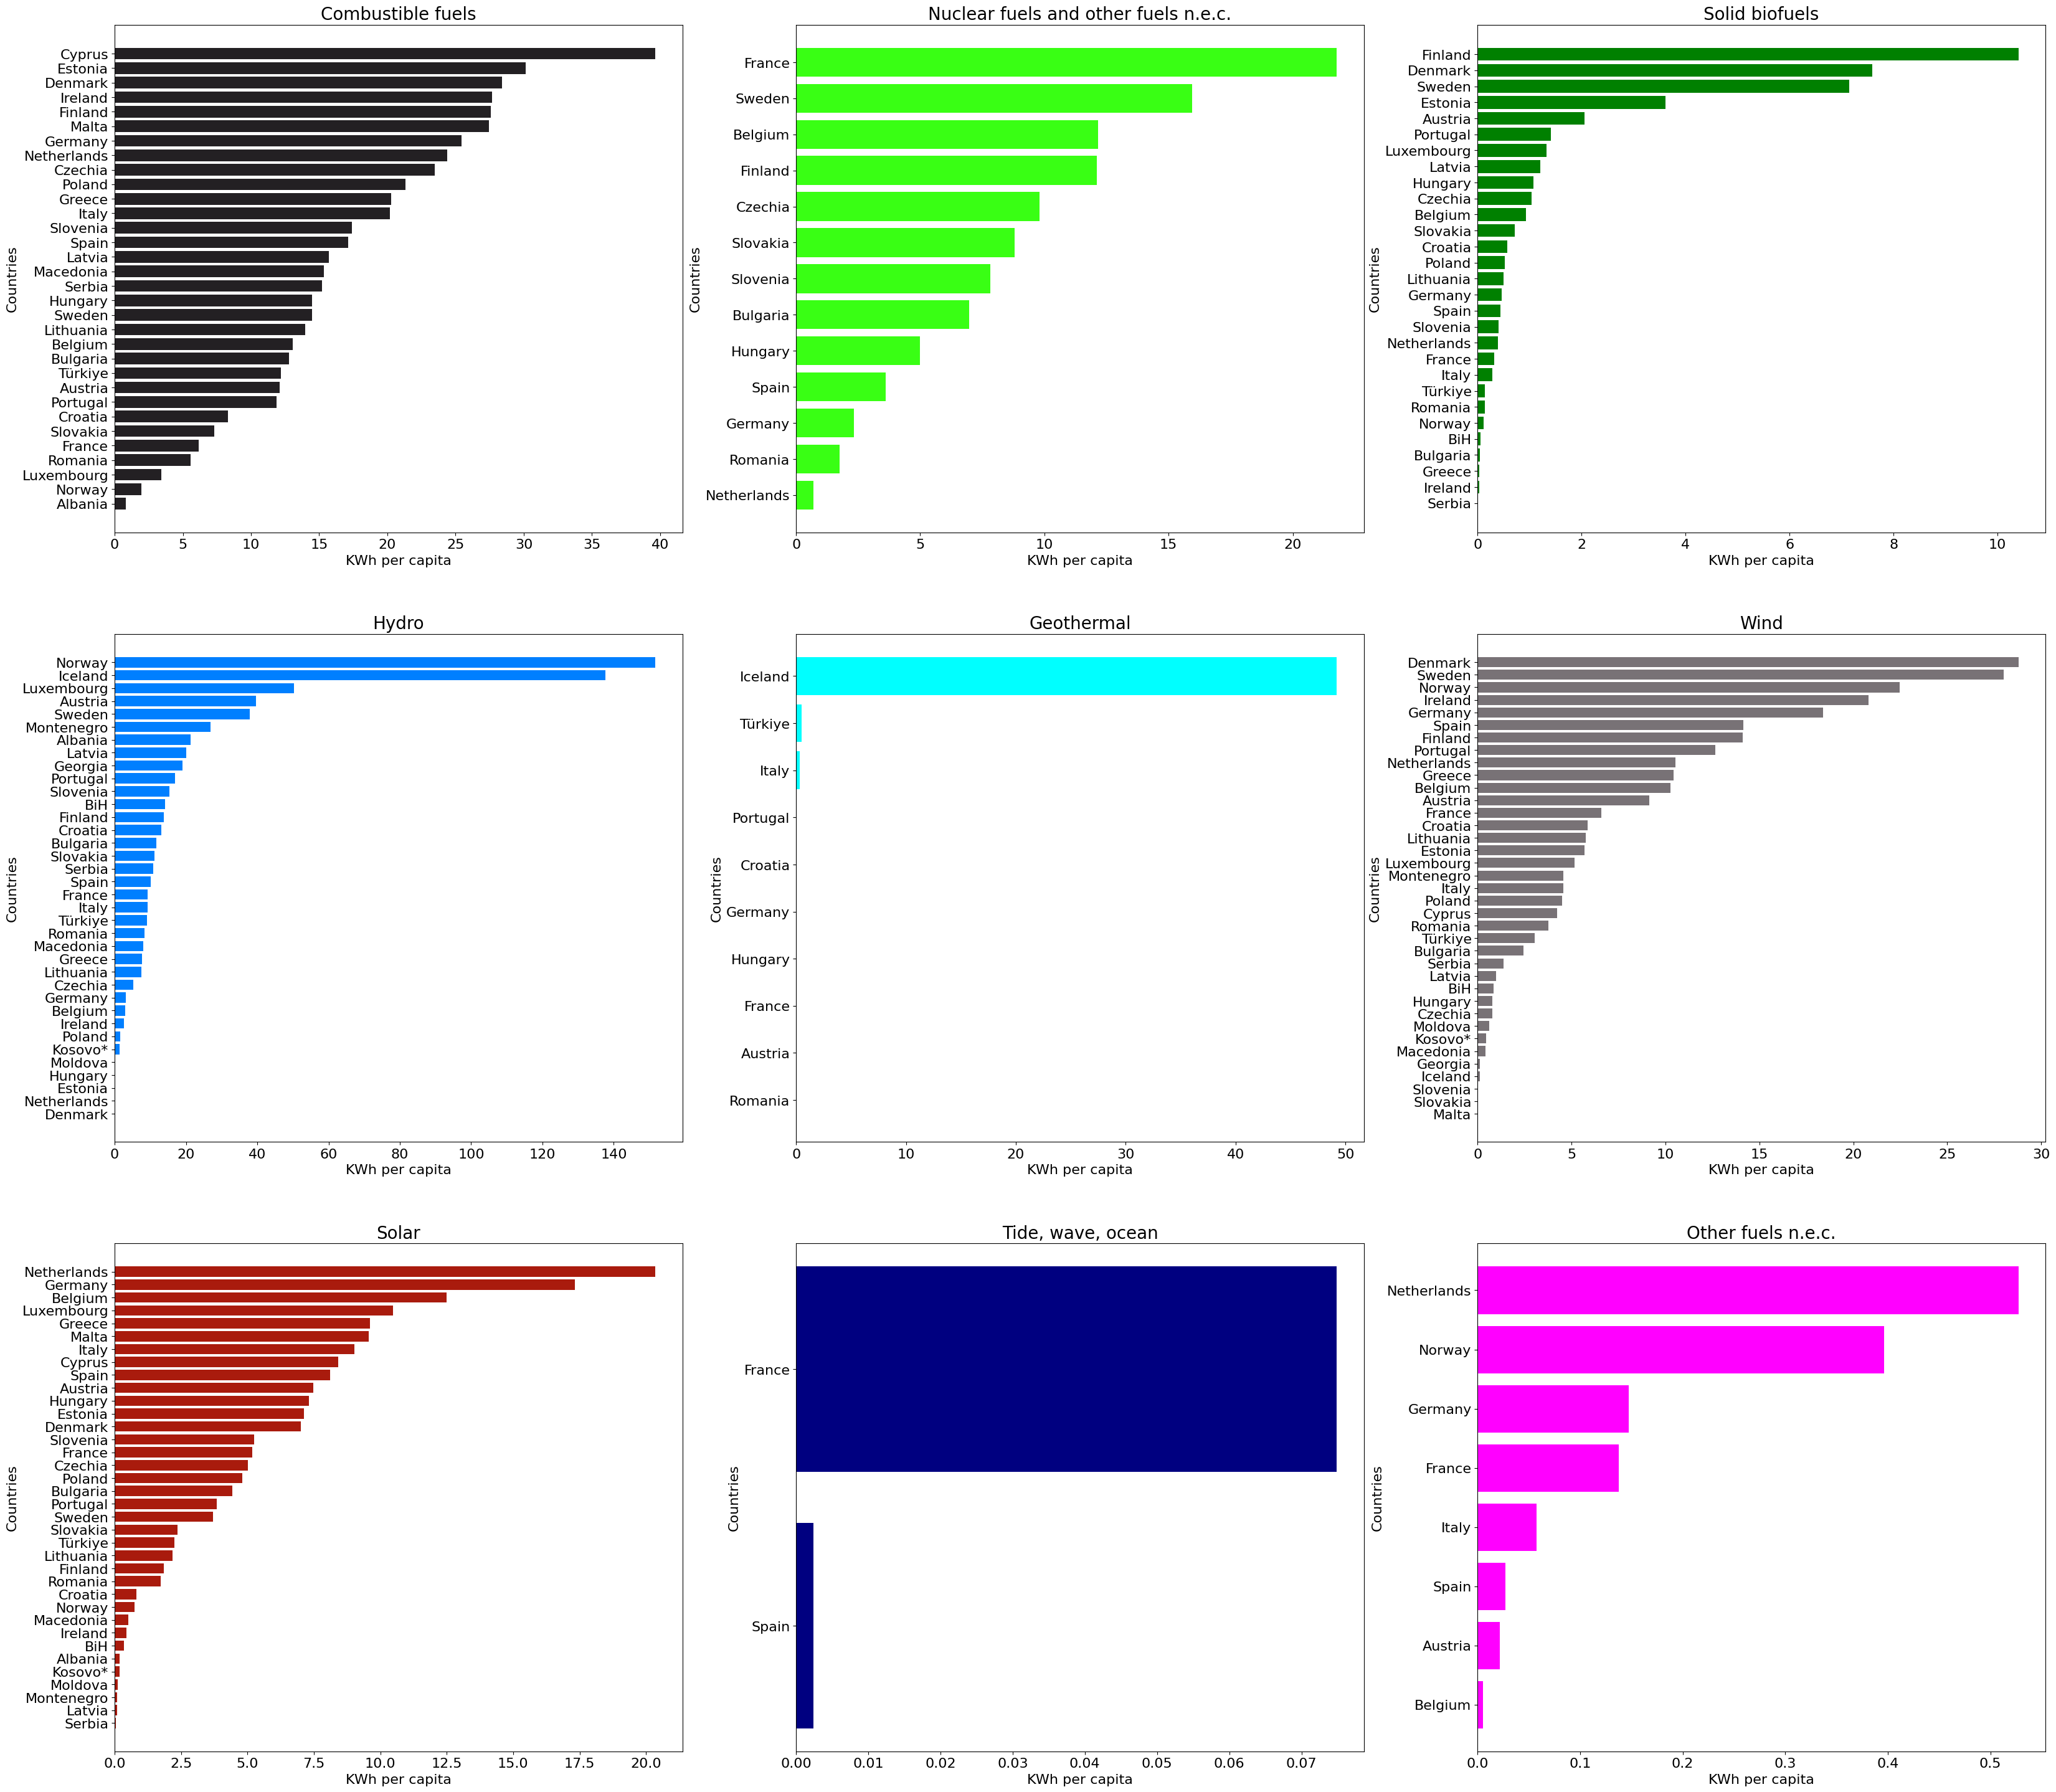

In [95]:
#         CF         N9000      R5100    RA100      RA200    RA300     RA400      RA500    X9900
colors= ['#232023', '#39FF14', 'green', '#007fff', 'cyan', '#787276', '#a91b0d', 'navy', '#FF00FF']

plt.figure(figsize=(40,36))

for energy_type, color, i in zip(data_combined_YEAR_reshaped.index, colors, range(len(data_combined_YEAR_reshaped.index))):
    row_data = data_combined_YEAR_reshaped.loc[energy_type]
    row_data = row_data.sort_values(axis=0, ascending=True)
    row_data = row_data.loc[row_data > 0]
    plt.subplot(3, 3, i+1)
    labels = [what_is(c, short=True) for c in row_data.index]
    labels = ['BiH' if label == 'Bosnia and Herzegovina' else label for label in labels]
    labels = ['Macedonia' if label == 'North Macedonia' else label for label in labels]
    plt.barh(labels, row_data.values, color=color)
    # plt.barh(row_data.index, row_data.values, color=color)
    # print(row_data.tail(10))
    plt.title(what_is(energy_type, short=True), fontsize=20)
    plt.ylabel("Countries", fontsize=16)
    plt.xlabel("KWh per capita", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()



<!--- 2. Kulk je slovenija v zaostanku glede renewable energije (kdaj so ostale države začele s proizvodnjo vs slovenija) --->
2. Primerjava napredka oz. zaostanka Slovenije pri proizvodnji obnovljive energije.
Primerjamo začetek proizvodnje v primerjavi z ostalimi državami.

In [33]:
def get_renewable_data_for_select_countries(comparison_countries):
    SIEC = data_renewables['siec'] == None
    for siec in siec_not_to_include:
        SIEC = np.logical_or(SIEC, data_renewables['siec'] == siec)
    SIEC = np.negative(SIEC)
    GEO = data_renewables['geo'] == None
    for geo in comparison_countries:
        GEO = np.logical_or(GEO, data_renewables['geo'] == geo)
    condition = np.logical_and(SIEC, GEO)
    return data_renewables.loc[condition].reset_index().drop('index', axis=1).drop(['plant_tec', 'freq', 'unit'], axis=1).set_index('geo')

In [34]:
def get_pop_data_for_select_countries(comparison_countries):
    GEO = data_pop_imputed['geo'] == None
    for geo in comparison_countries:
        GEO = np.logical_or(GEO, data_pop_imputed['geo'] == geo)
    return data_pop_imputed.loc[GEO].set_index('geo')

In [35]:
def nomalize_renewable_data_for_countries(comparison_countries):
    data = get_renewable_data_for_select_countries(comparison_countries)
    pop = get_pop_data_for_select_countries(comparison_countries)
    
    rearange_columns = data.keys().to_list()
    rearange_columns.pop(0)
    rearange_columns.append('siec')
    data = data[rearange_columns]
    
    list_of_siec=[]
    for row in range(len(data)):
        siec = data.iloc[row]['siec']
        data.iloc[row] = data.iloc[row] * 24 * 1000 / pop.iloc[row % len(pop)]
        list_of_siec.append(siec)

    data.siec = list_of_siec
    
    return data

In [36]:
comparison_countries = {'NO', 'DE', 'FR', 'SI', 'BE', 'DK', 'NL', 'ES', 'CZ', 'AL'}
comparison_countries_all = {geo for geo in data_renewables.geo if geo not in {'EA20', 'EU27_2020', 'UK'}}

In [37]:
comparison_countries = {
  'SI', 
  'DE', 
  'FI', 
  'TR', 
  'AT', 
  'HR', 
  'CZ', 
  }
data_renewables_small = nomalize_renewable_data_for_countries(comparison_countries)

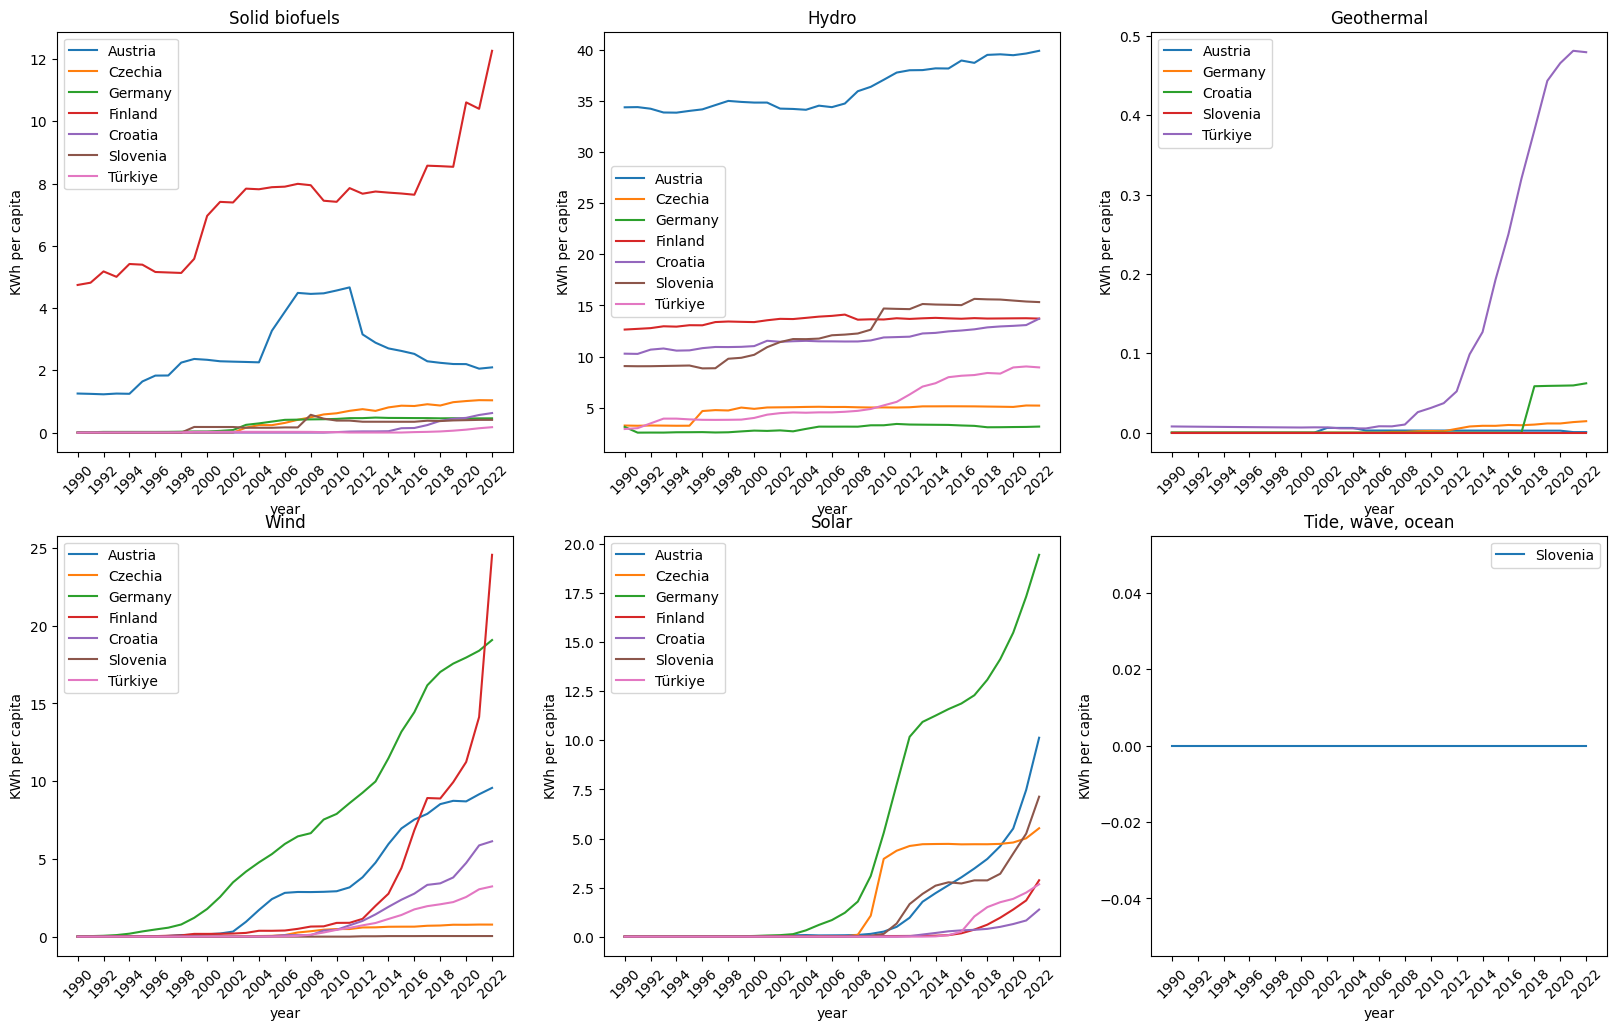

In [38]:
plt.figure(figsize=(20, 12))
for siec, i in zip(np.unique(data_renewables_small.siec), range(len(np.unique(data_renewables_small.siec)))):
    # print(siec)
    data = data_renewables_small.loc[data_renewables_small.siec == siec].drop('siec', axis=1)
    plt.subplot(2, 3, i+1)
    for power, country in zip(data.values, data.index):
        if np.sum(power) == 0 and country != 'SI':
            continue
        plt.plot(data.keys(), power, label=what_is(country, short=True))
        plt.title(what_is(siec, short=True))
        plt.xlabel("year")
        plt.ylabel("KWh per capita")
        plt.legend()
        plt.xticks(data.keys()[::2], rotation=45) # izpustimo vsako drugo letnico
plt.show()

In [39]:
data_renewables_all = nomalize_renewable_data_for_countries(comparison_countries_all).fillna(0)

In [40]:
def draw_graph_renewables(group, siec, figsize=(10, 10)):
    data = nomalize_renewable_data_for_countries(group)
    
    data = data.loc[data.siec == siec].drop('siec', axis=1)
    plt.figure(figsize=(8, 5)) # (8, 5)
    for power, country in zip(data.values, data.index):
        plt.plot(data.keys(), power, label=what_is(country, short=True))
        plt.title(what_is(siec, short=True))
        plt.xlabel("year")
        plt.ylabel("KWh per capita")
        plt.legend()
        plt.xticks(data.keys()[::2], rotation=45)
    plt.show()

In [41]:
import scipy.cluster.hierarchy as sch
def print_clusters_renewable(data, t = 100, method="average", metric="cityblock", criterion="distance", console=False, graph=True, graphs_of_groups=False, siec=None):
    if graphs_of_groups and siec is None:
        raise ValueError("graphs_of_groups is True requre 'siec' parameter")
    # * method='single' 
    # * method='complete'
    # * method='average'
    # * method='weighted' 
    # * method='centroid'
    # * method='median' 
    # * method='ward' 
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
    
    # metric https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist
    L = sch.linkage(data.iloc[:, 0:-1], method=method, metric=metric)
    
    # * criterion='inconsistent'
    # * criterion='distance'
    # * criterion='maxclust'
    # * criterion='monocrit'
    # * criterion='maxclust_monocrit' 
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html
    predictions = sch.fcluster(L, t=t, criterion=criterion).ravel()

    groups = defaultdict(list)
    for a in np.unique(predictions):
        groups[a]
        
    for name, prediction in zip(data.index, predictions):
        groups[prediction].append(name)
        
    
    if console:
        
        for group, countries in groups.items():
            print(f"Group {group}:")
            for country in countries:
                print(f"  '{country}', {what_is(country, short=True)}")
    
    if graph:
        plt.figure(figsize=(35, 6))
        labels = [what_is(country, short=True) for country in data.index]
        D = sch.dendrogram(L, labels=labels, leaf_font_size=15)
        plt.plot([0, 1000], [t, t], "k--")
        plt.ylabel("Razdalja")
        plt.xticks(rotation=90)
        plt.show()
        
    if graphs_of_groups:
        for group in groups.values():
            draw_graph_renewables(group, siec)

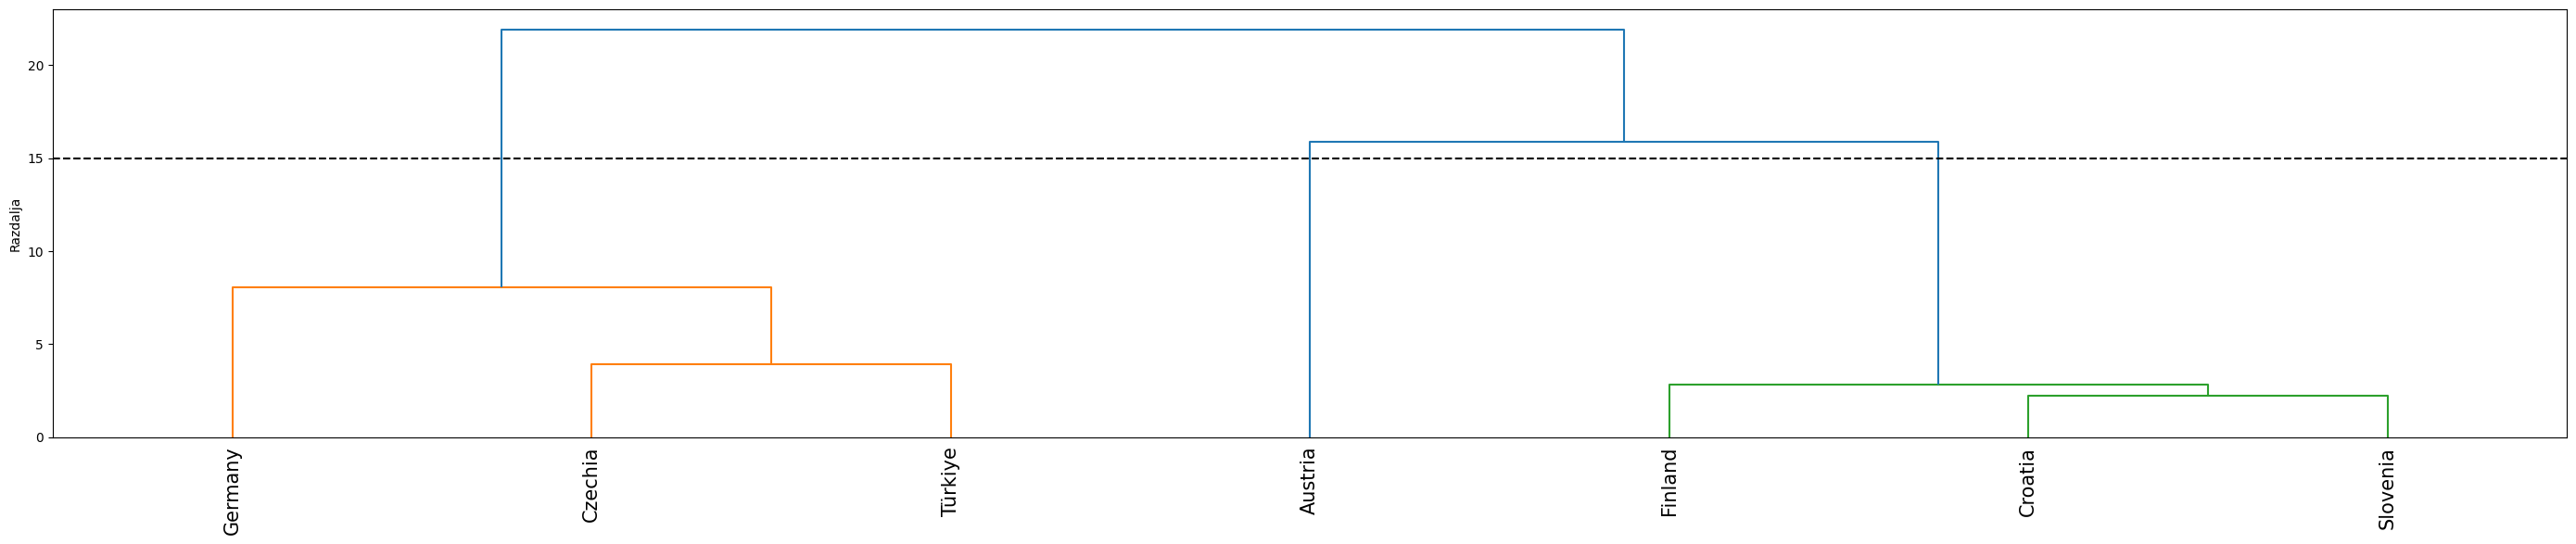

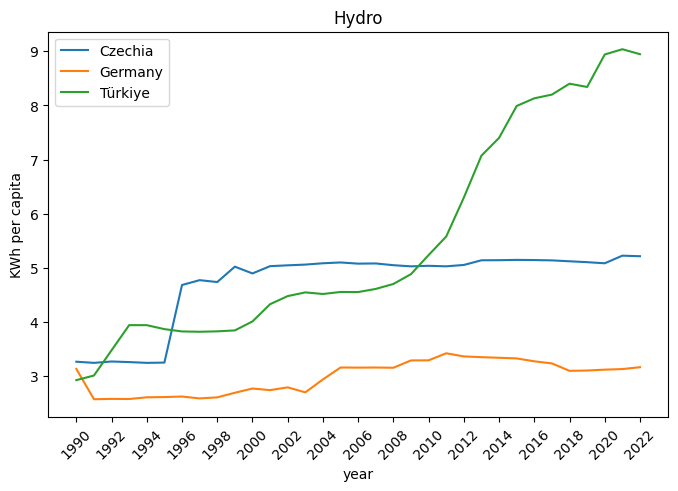

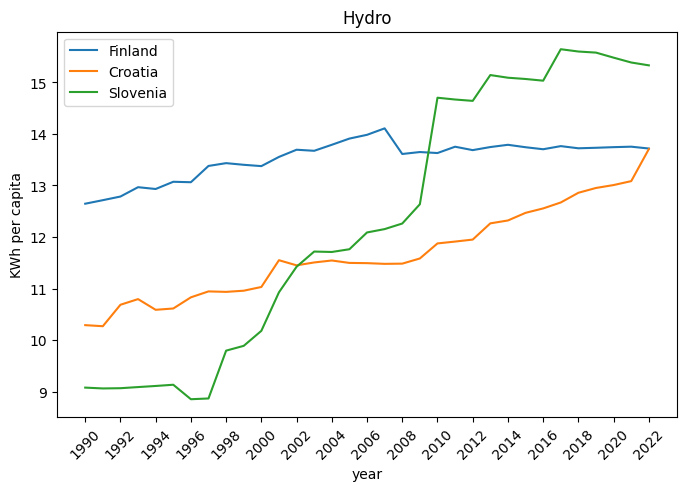

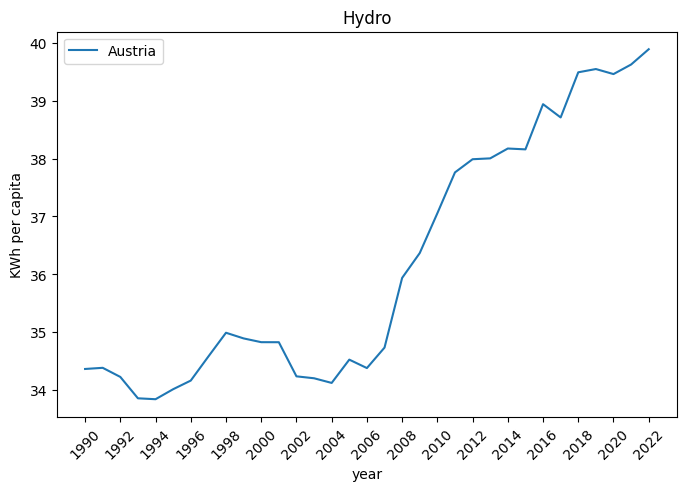

In [42]:
data_renewables_small_RA100 = data_renewables_small.loc[data_renewables_small.siec == 'RA100']
print_clusters_renewable(data_renewables_small_RA100, t=15, method='weighted', metric='canberra', graph=True, graphs_of_groups=True, siec='RA100') 

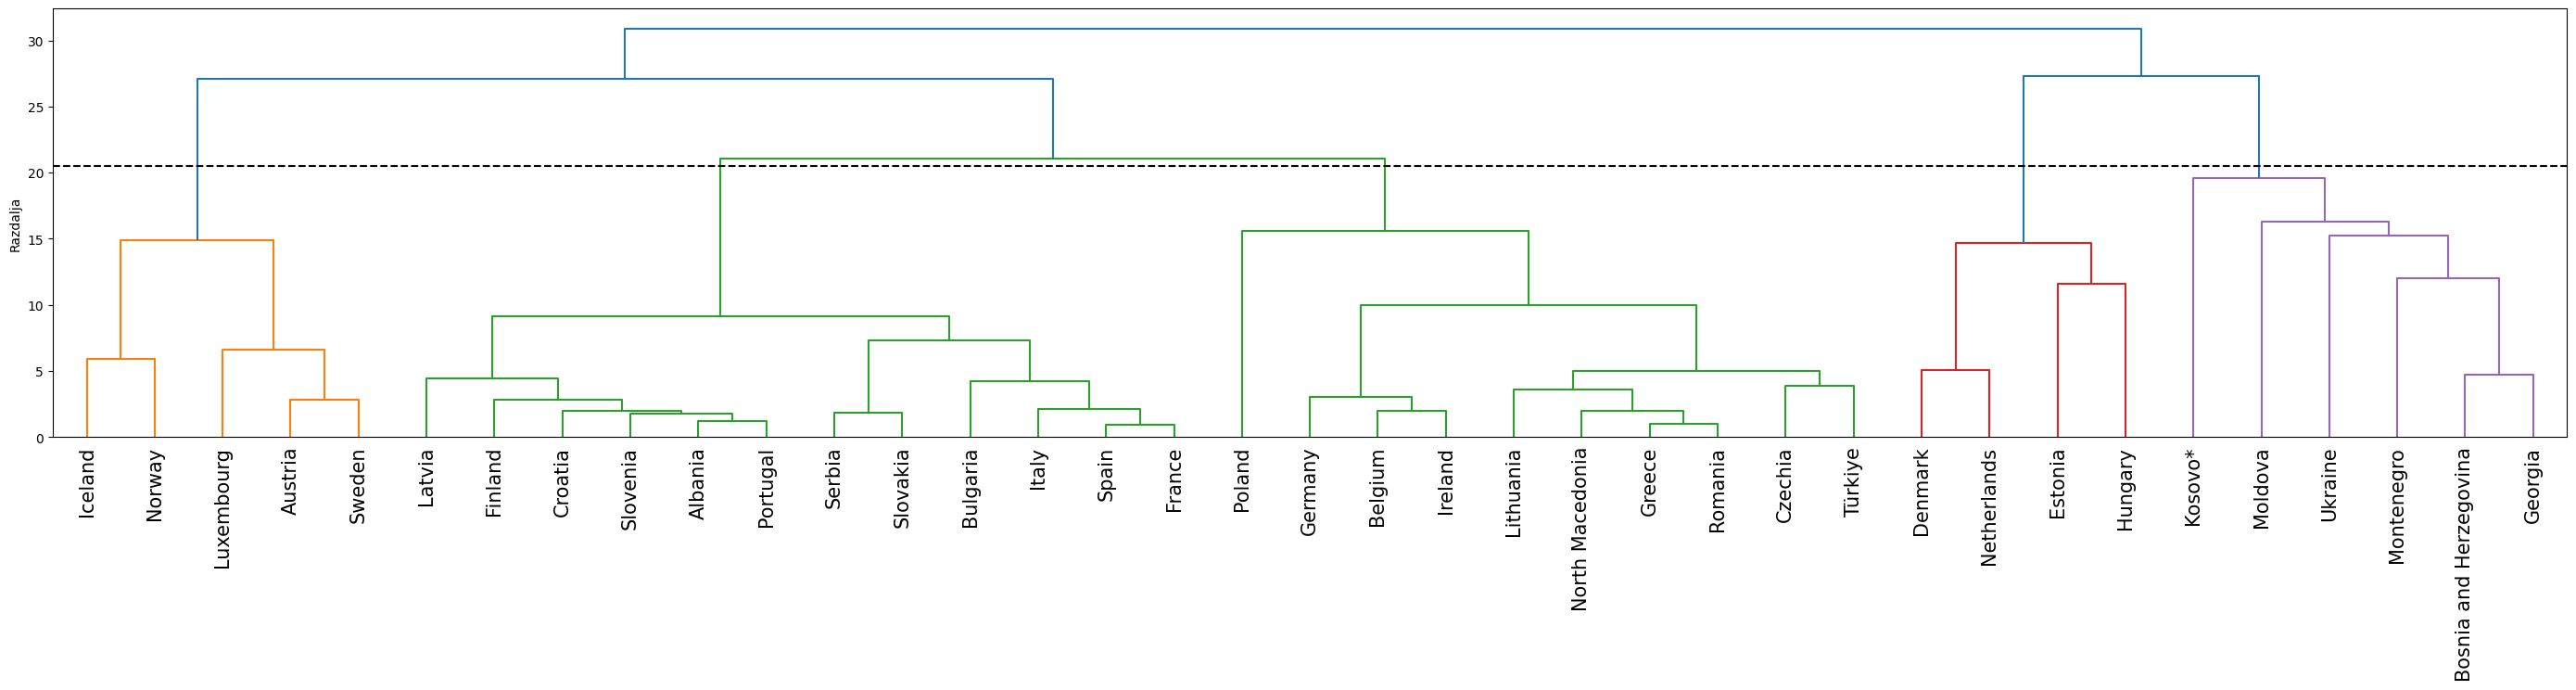

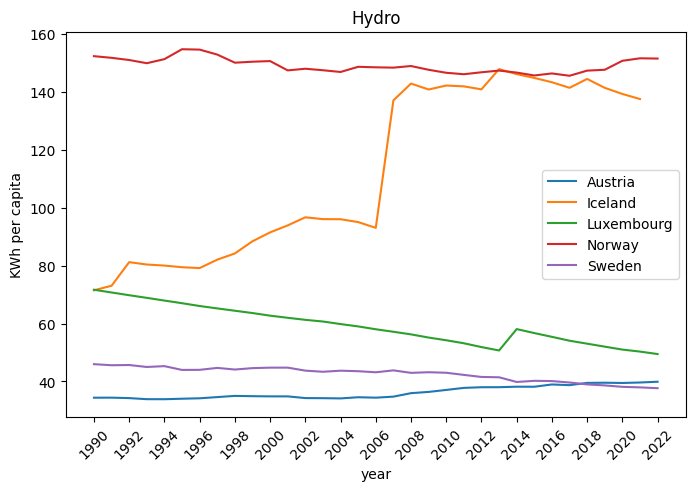

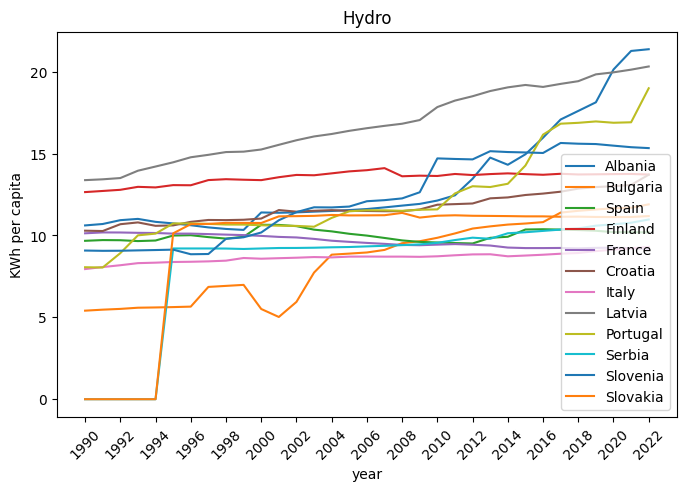

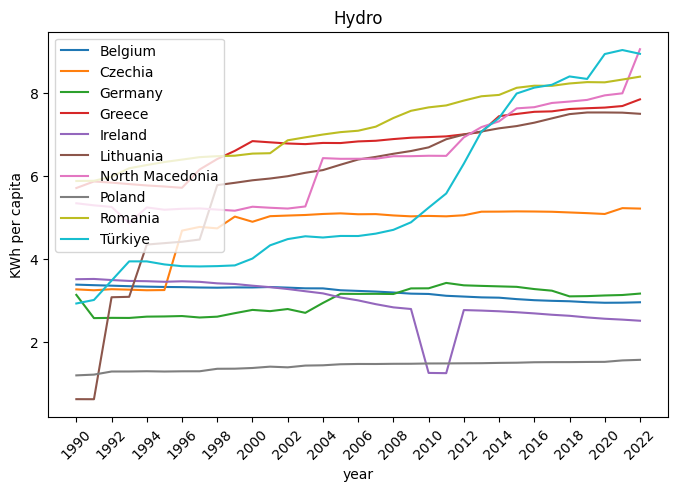

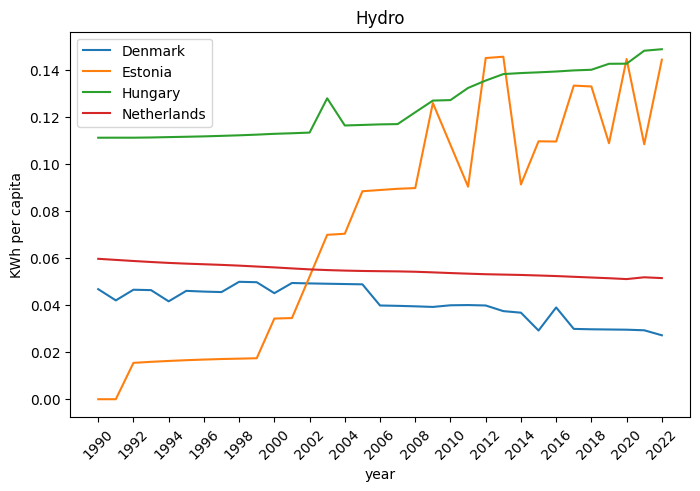

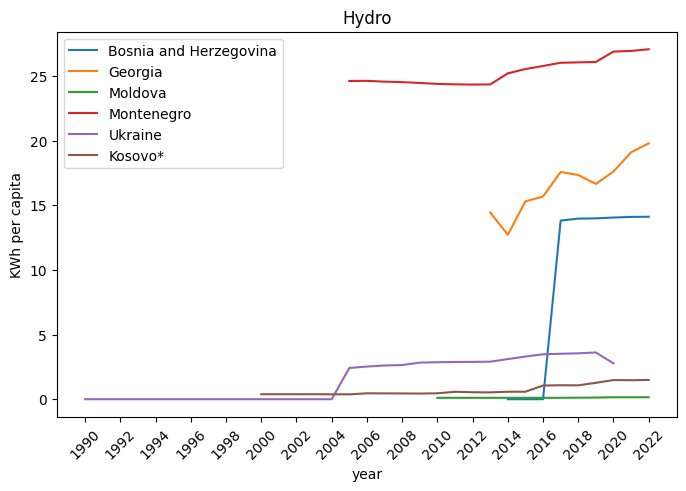

In [43]:
data_renewables_all_RA100 = data_renewables_all.loc[data_renewables_all.siec == 'RA100']
data_renewables_all_RA100 = data_renewables_all_RA100.loc[(data_renewables_all_RA100.drop('siec', axis=1 ) > 0 ).any(axis=1)]
print_clusters_renewable(data_renewables_all_RA100, t=20.5, method='weighted', metric='canberra', console=False, graph=True, graphs_of_groups=True, siec='RA100') 
# for investigation metric = canberra
# method = 'weighted' , complete

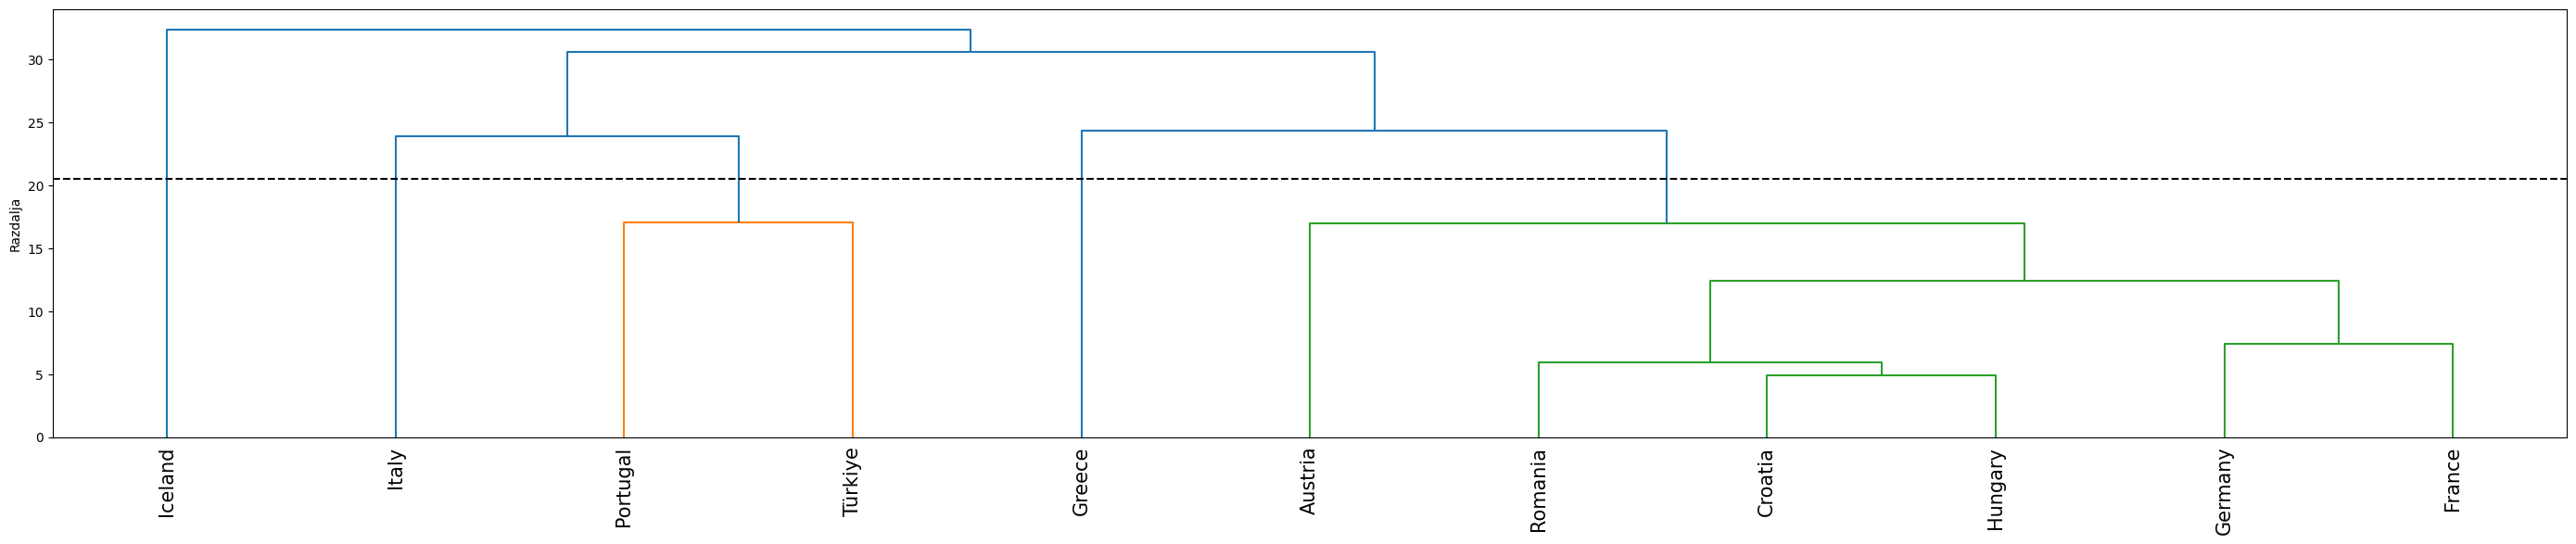

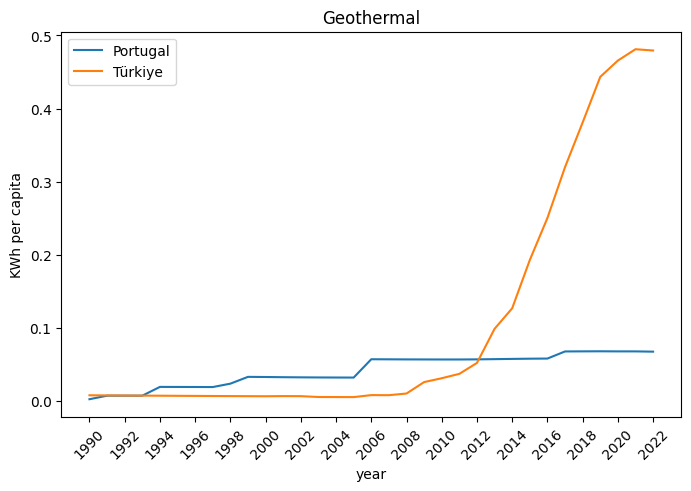

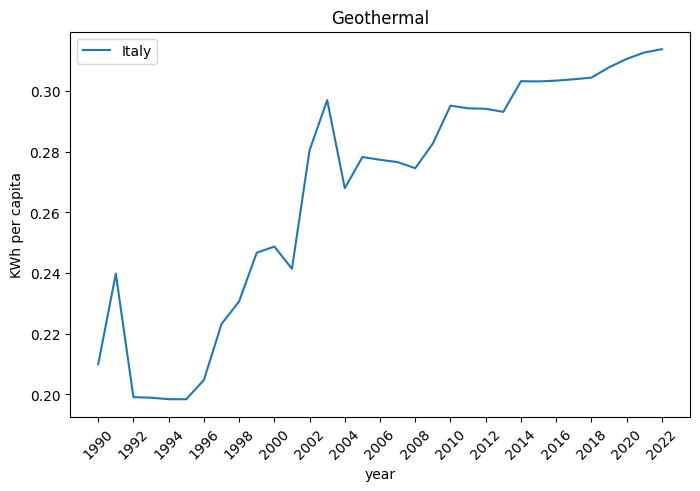

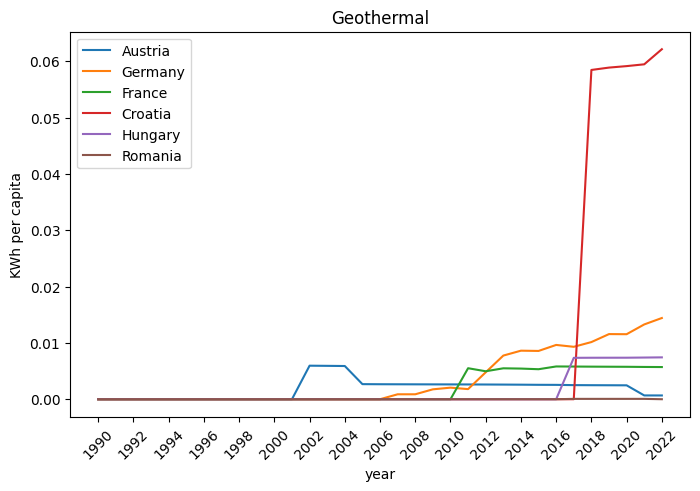

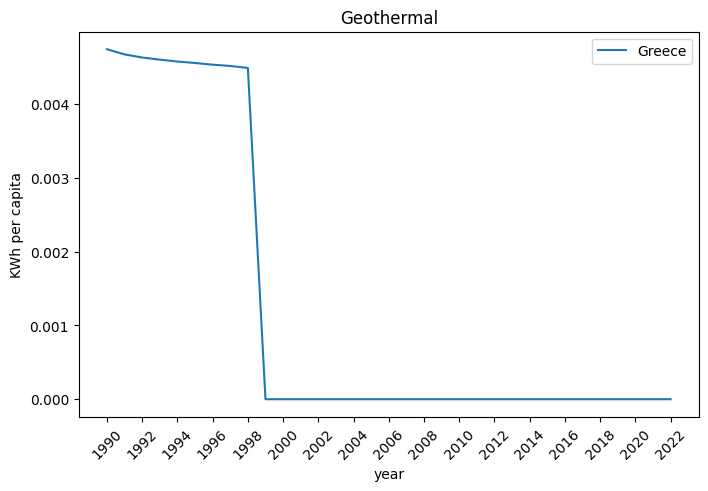

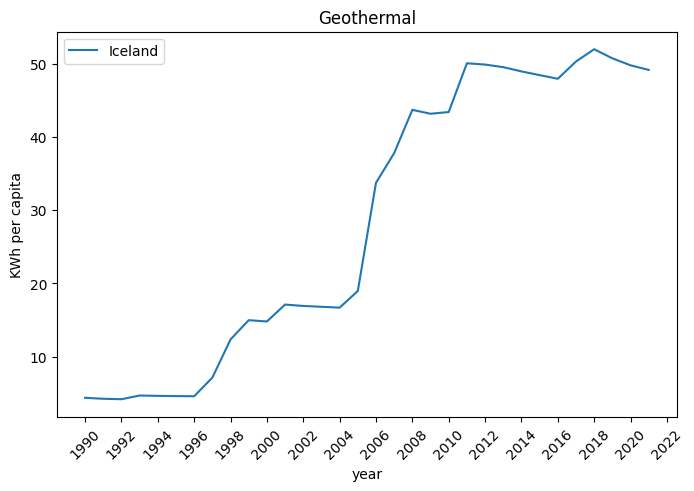

In [44]:
data_renewables_all_RA200 = data_renewables_all.loc[data_renewables_all.siec == 'RA200']
data_renewables_all_RA200 = data_renewables_all_RA200.loc[(data_renewables_all_RA200.drop('siec', axis=1 ) > 0 ).any(axis=1)]
print_clusters_renewable(data_renewables_all_RA200, t=20.5, method='weighted', metric='canberra', console=False, graph=True, graphs_of_groups=True, siec='RA200') 

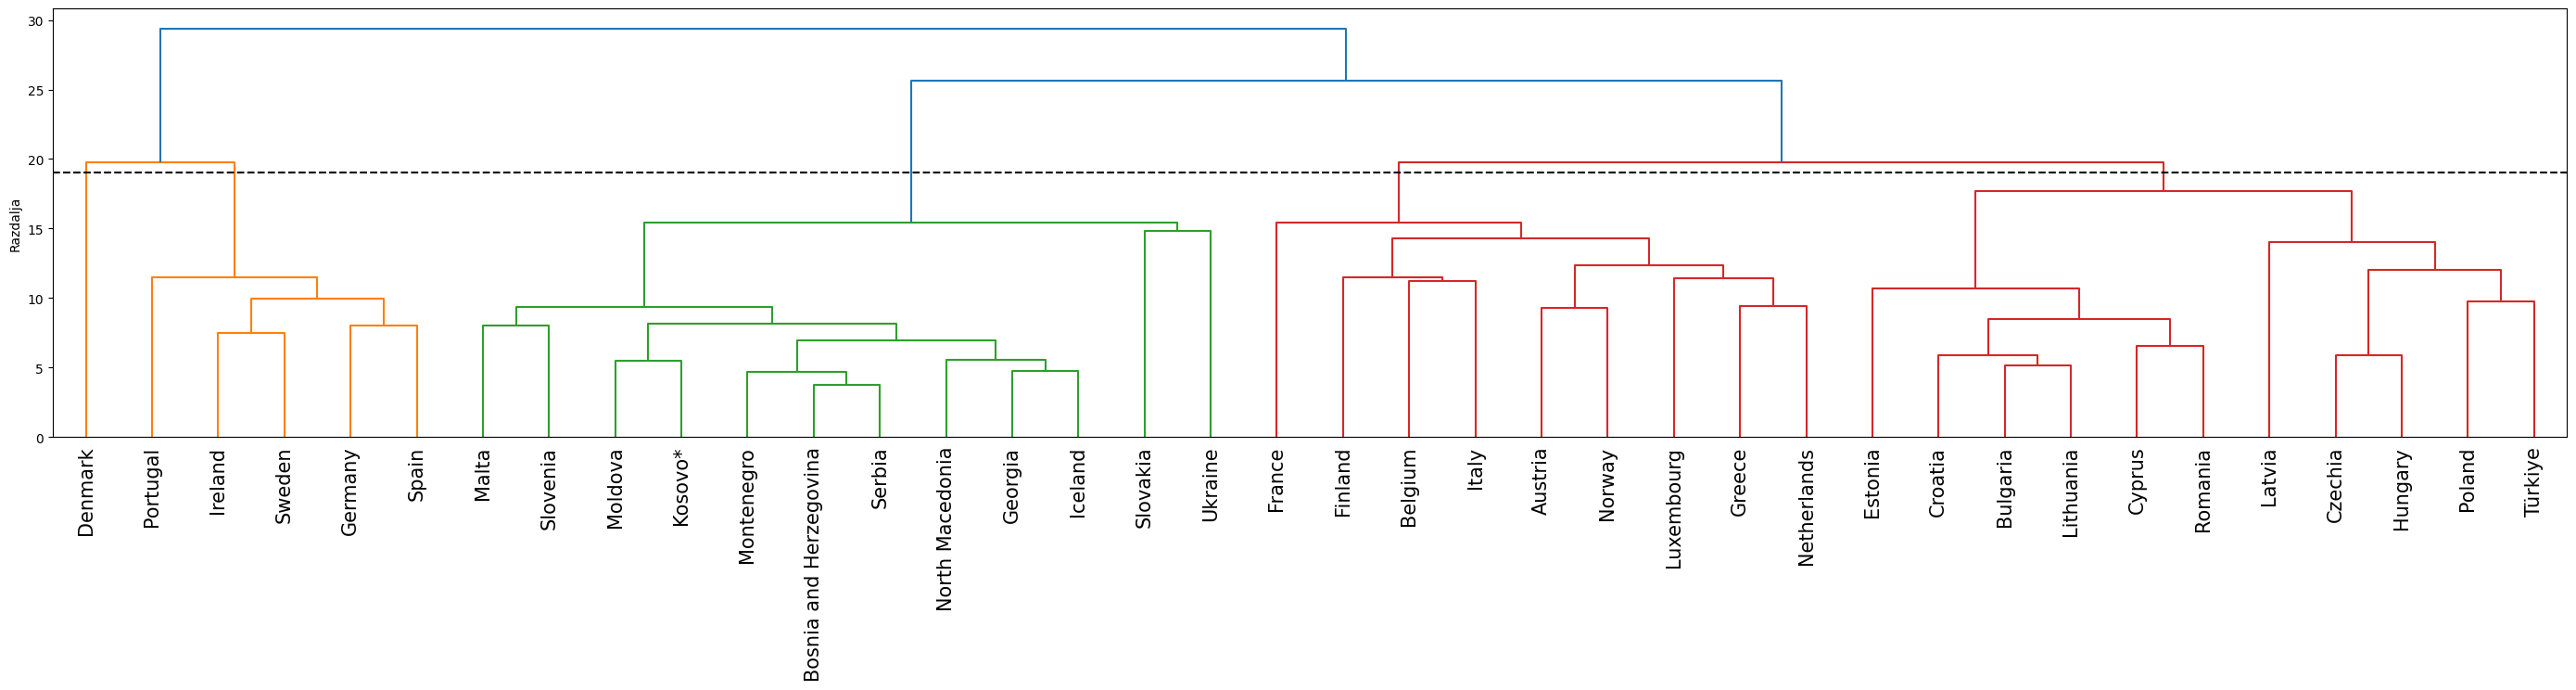

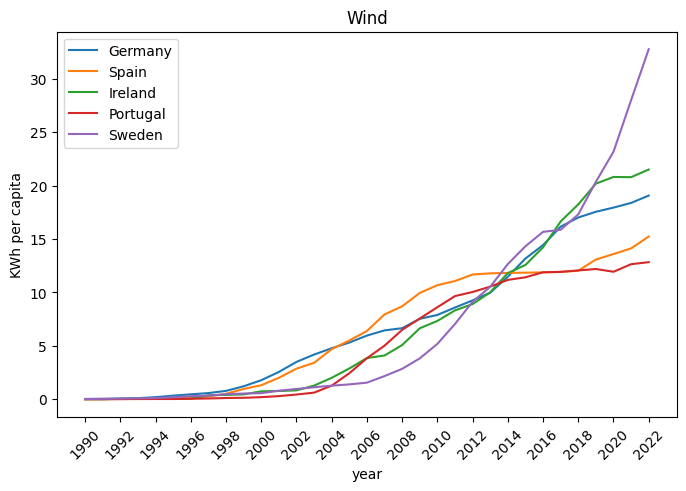

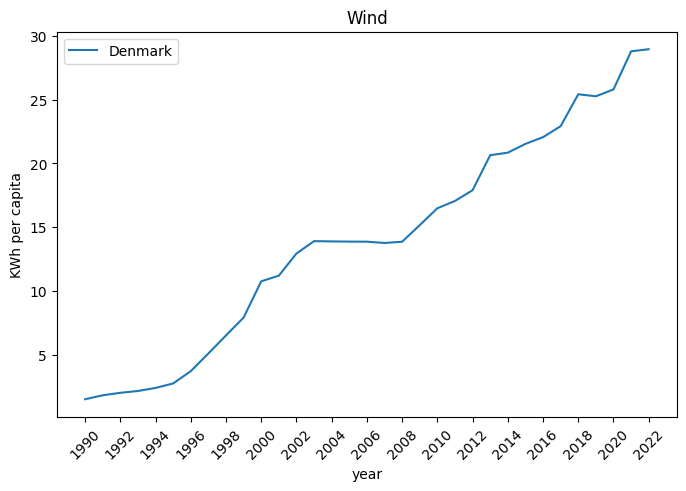

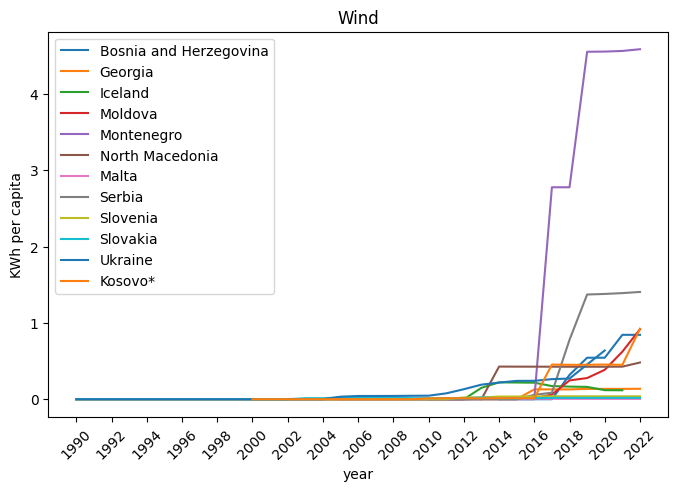

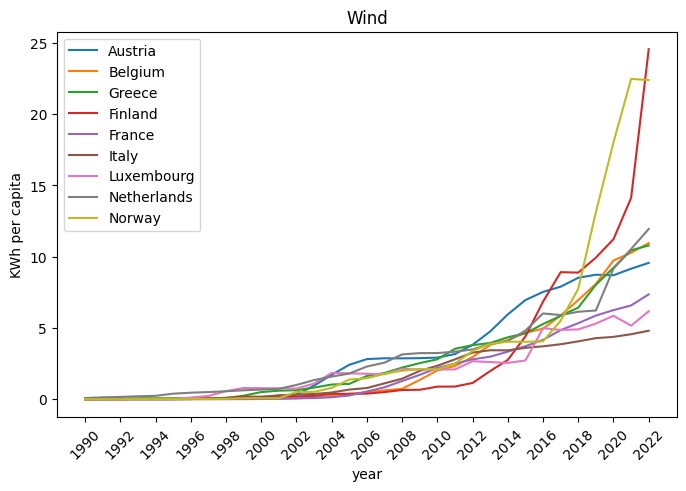

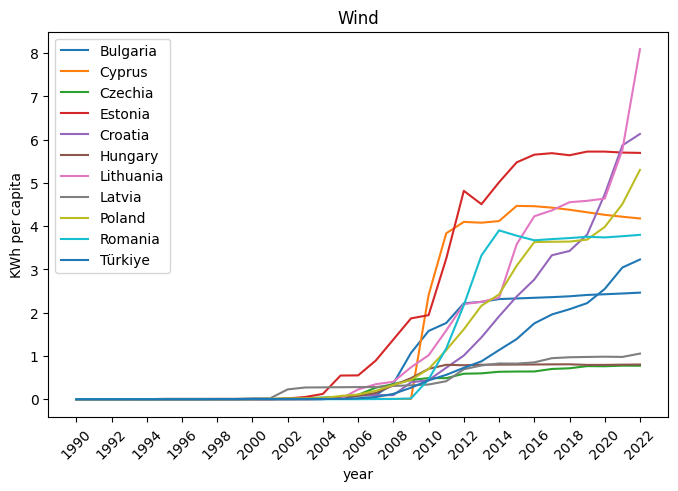

In [45]:
data_renewables_all_RA300 = data_renewables_all.loc[data_renewables_all.siec == 'RA300']
data_renewables_all_RA300 = data_renewables_all_RA300.loc[(data_renewables_all_RA300.drop('siec', axis=1 ) > 0 ).any(axis=1)]
print_clusters_renewable(data_renewables_all_RA300, t=19, method='weighted', metric='canberra', console=False, graph=True, graphs_of_groups=True, siec='RA300') 

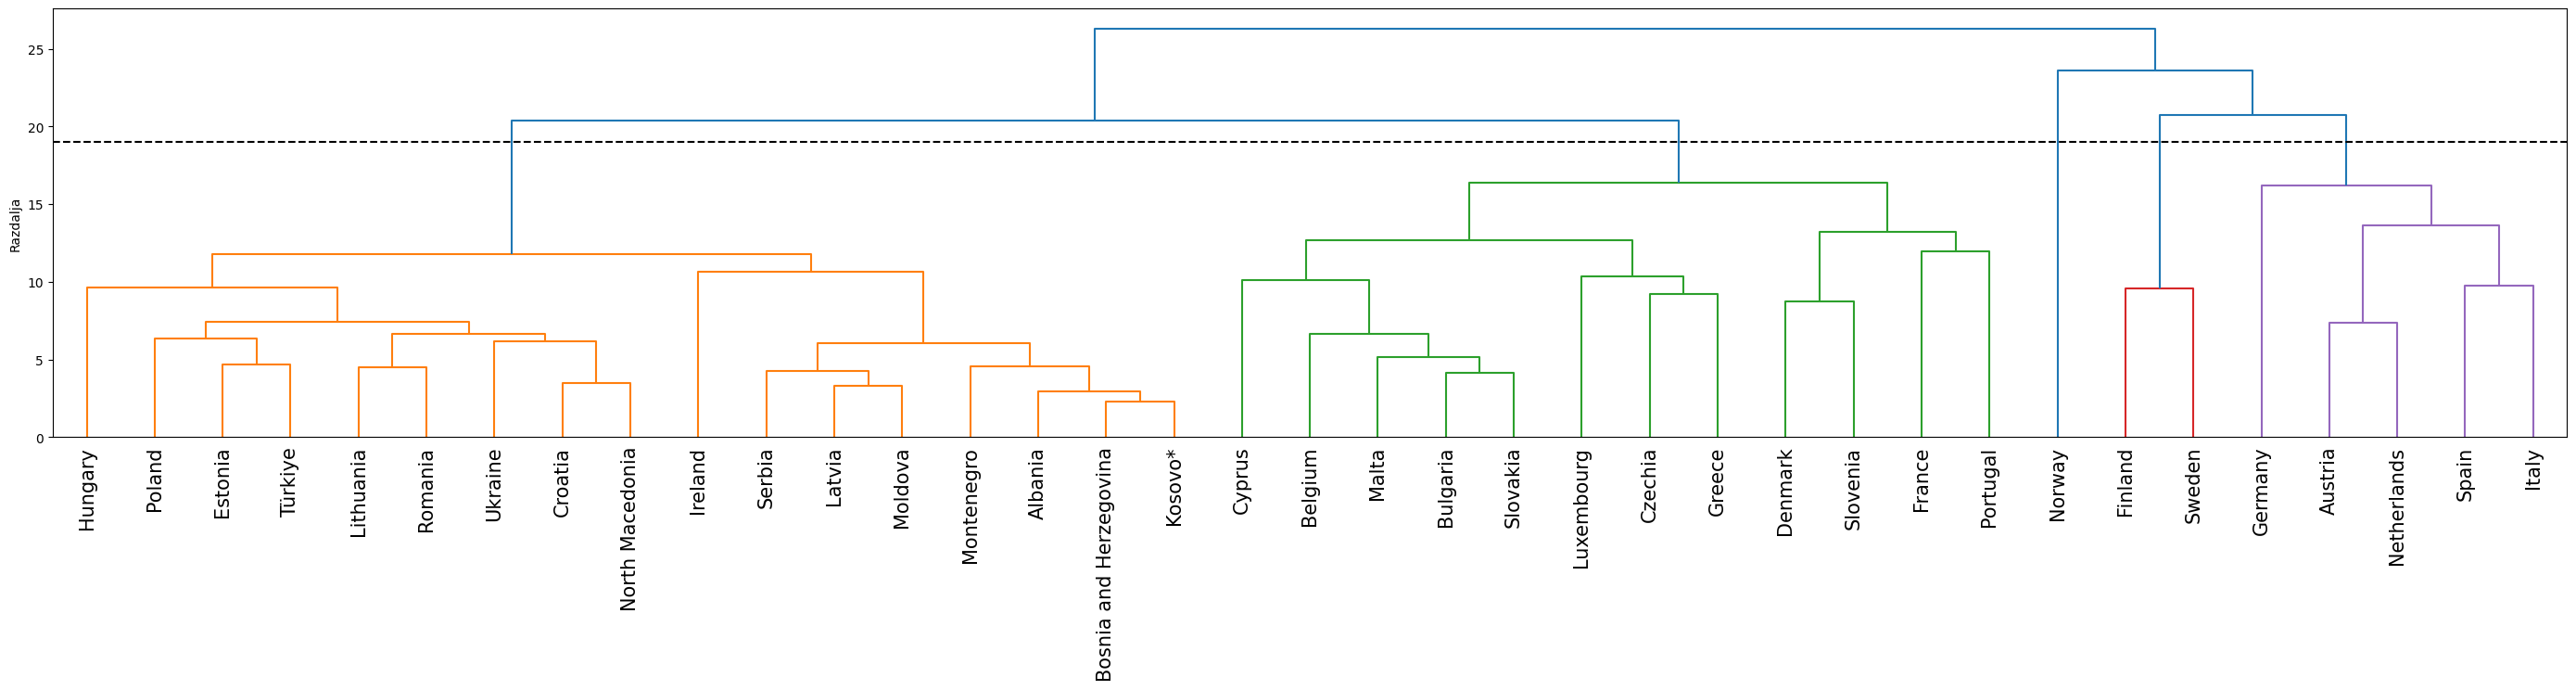

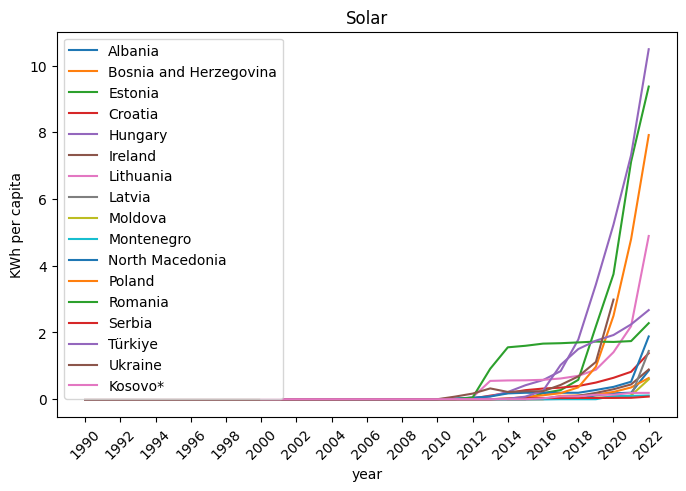

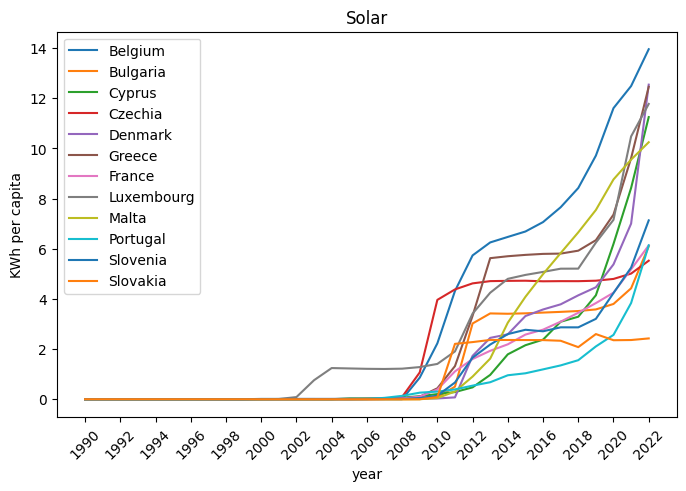

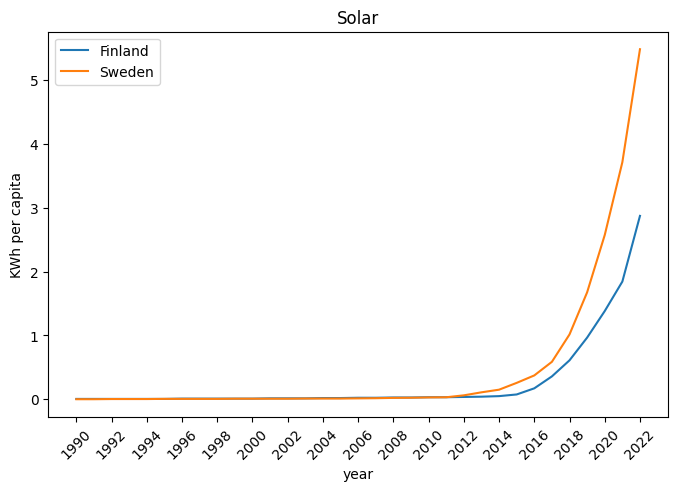

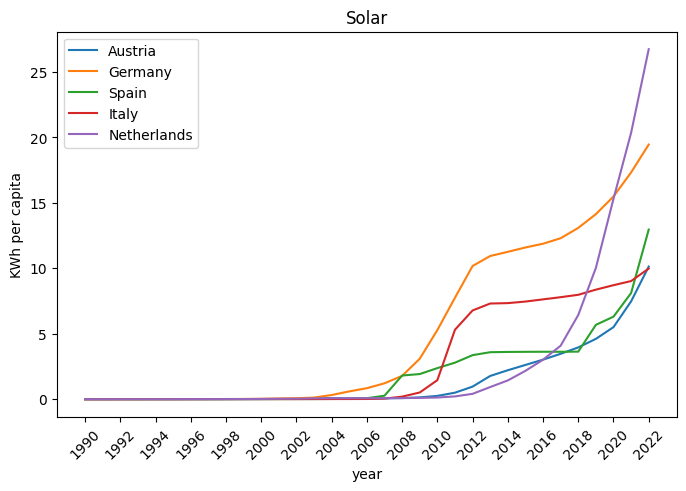

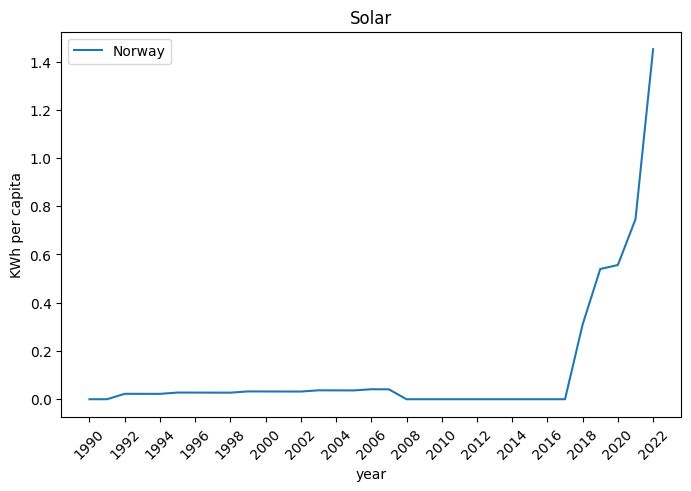

In [46]:
data_renewables_all_RA400 = data_renewables_all.loc[data_renewables_all.siec == 'RA400']
data_renewables_all_RA400 = data_renewables_all_RA400.loc[(data_renewables_all_RA400.drop('siec', axis=1 ) > 0 ).any(axis=1)]
print_clusters_renewable(data_renewables_all_RA400, t=19, method='weighted', metric='canberra', console=False, graph=True, graphs_of_groups=True, siec='RA400') 

<!-- 3. Keri tip energije proizvaja največ elektrike v evropi -->
3. Na kateri način se pridobi največ električne energije v Evropi?

In [47]:
####   filtriranje data setov

# # is_PRODUCING = data_renewables['operator'] == 'PRR_MAIN'
# # is_TOTAL = data_renewables['siec'] != 'TOTAL'
# is_ACTIVE = data_renewables['plant_tec'] == 'CAP_NET_ELC'
# is_GEO = np.logical_and(data_renewables['geo'] != 'EA20', data_renewables['geo'] != 'EU27_2020')
# for country in countries_only_in_renewables:
#     is_GEO = np.logical_and(is_GEO, data_renewables['geo'] != country)
# condition = np.logical_and(is_GEO, is_ACTIVE)
# # condition = np.logical_and(condition, is_TOTAL)
# # condition = np.logical_and(condition, is_GEO)
# condition_2 = condition
# # data_renewables.loc[condition]

# is_PRODUCING = data_other['operator'] == 'PRR_MAIN'
# # is_TOTAL = data_other['siec'] != 'TOTAL'
# is_ACTIVE =  data_other['plant_tec'] == 'CAP_NET_ELC'
# is_GEO = np.logical_and(data_other['geo'] != 'EA20', data_other['geo'] != 'EU27_2020')
# condition = np.logical_and(is_PRODUCING, is_ACTIVE)
# # condition = np.logical_and(condition, is_TOTAL)
# condition = np.logical_and(condition, is_GEO)
# condition_1 = condition
# # data_other.loc[condition]

condition_combined = np.logical_and(data_combined['geo'] != 'EA20', data_combined['geo'] != 'EU27_2020')

In [48]:
####  ustvarjanje zdruzenega dataseta
def get_vsota_energij_po_vrsti(data):
    temp = {}
    temp['siec'] = []
    for year in data.keys()[2:]:
        temp[year] = []

    for siec in np.unique(data['siec']):
        if siec in siec_not_to_include:
            continue
        temp['siec'].append(siec)
        con = np.logical_and(data['siec'] == siec, condition_combined)
        for year in data.keys()[2:]:
            temp[year].append(np.sum(data.loc[con][year])) 
        
    vsota_energij_po_vrsti = pd.DataFrame(temp)
    vsota_energij_po_vrsti = vsota_energij_po_vrsti.sort_values('siec')
    return vsota_energij_po_vrsti

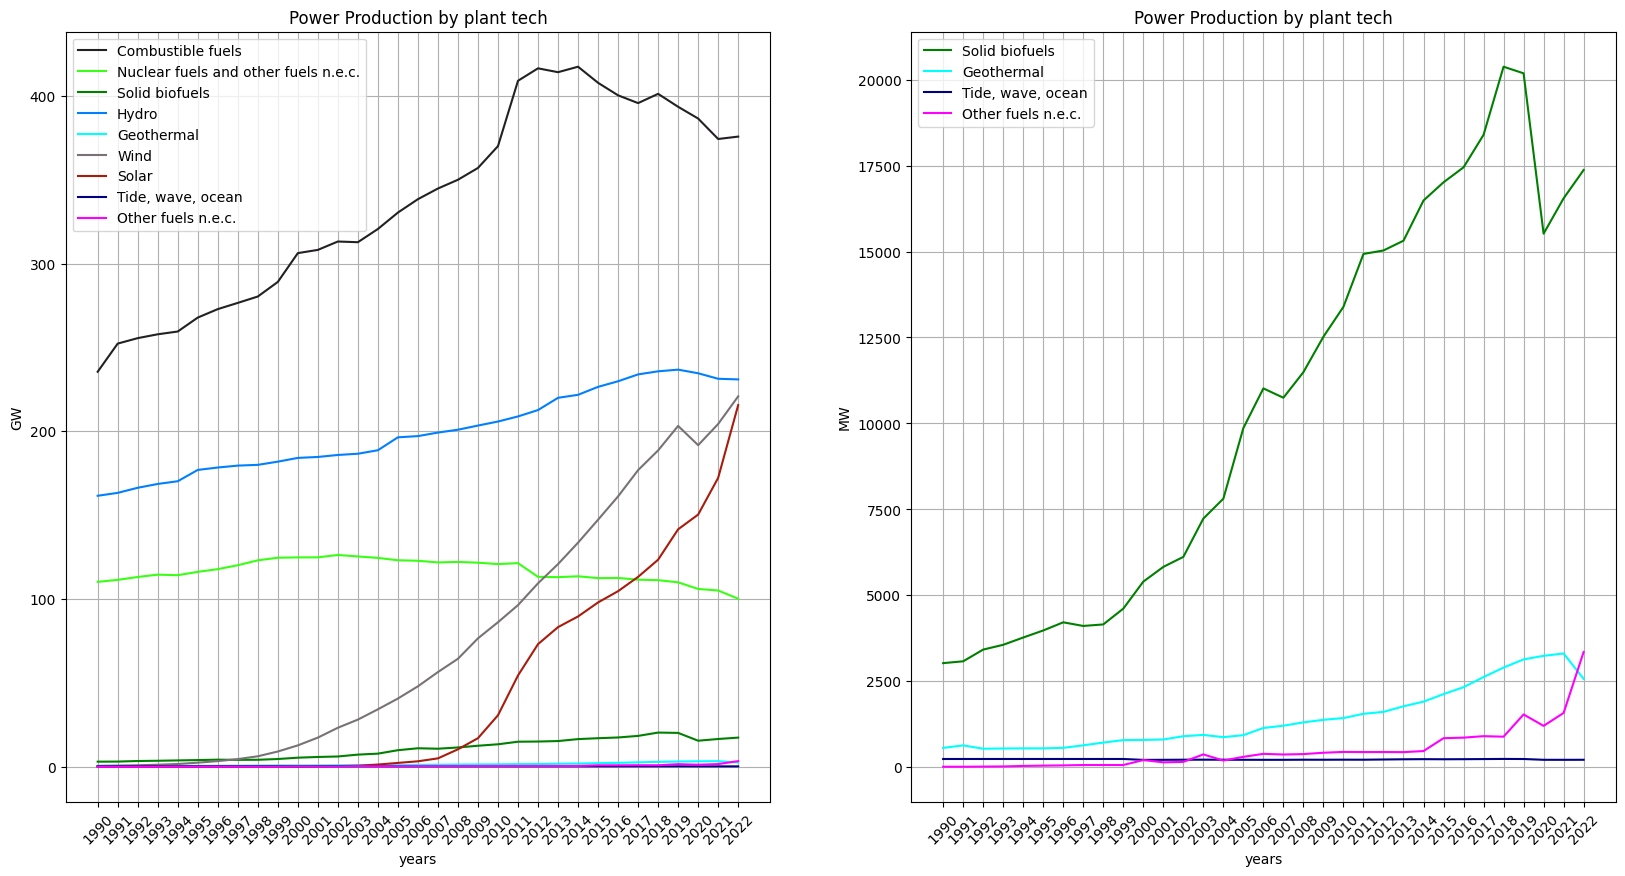

In [49]:
vsota_energij_po_vrsti = get_vsota_energij_po_vrsti(data_combined)
years = vsota_energij_po_vrsti.columns.tolist()[1:]

# vsota_energij_po_vrsti.plot(x='1990', y='1992')
fig2 = {'R5100', 'X9900', 'RA500', 'RA200'}

plt.figure(figsize=(20, 10))
for row, colour in zip(vsota_energij_po_vrsti.values, colors):
    if row[0] in fig2:
        plt.subplot(1, 2, 2)
        plt.plot(years, row[1:], label=what_is(row[0], short=True), color=colour)
    plt.subplot(1, 2, 1)
    plt.plot(years, [power / 1000 for power in row[1:]], label=what_is(row[0], short=True), color=colour)

plt.subplot(1, 2, 1)
plt.ylabel('GW')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('Power Production by plant tech')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.ylabel('MW')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('Power Production by plant tech')
plt.grid(True)
plt.legend()

plt.show()


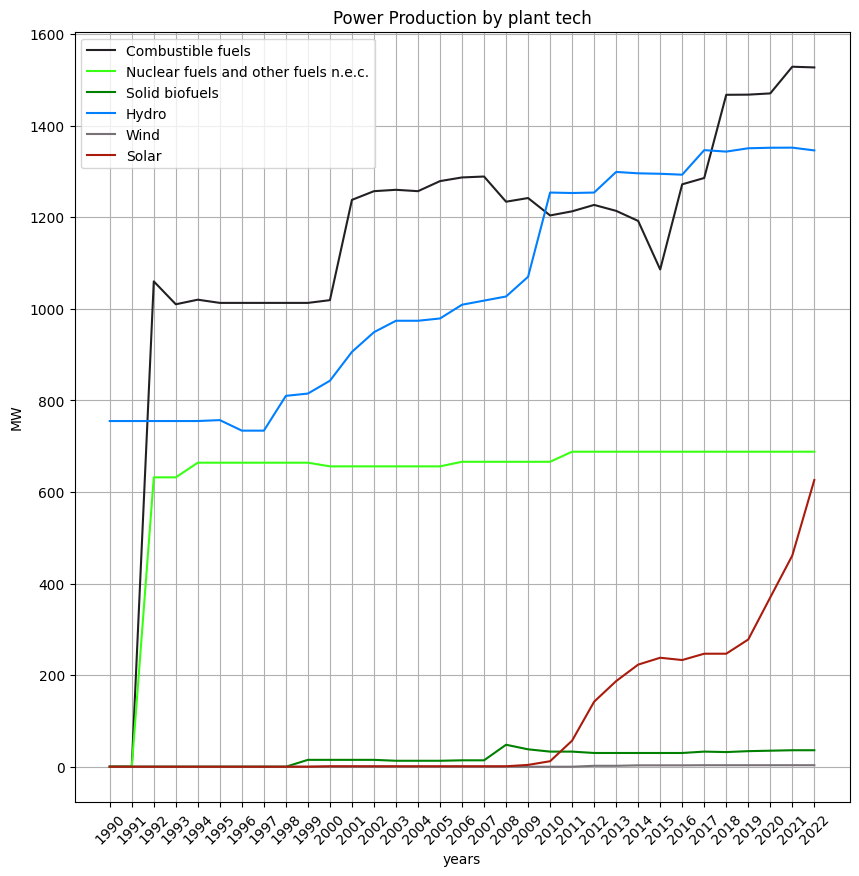

In [50]:
vsota_energij_po_vrsti = get_vsota_energij_po_vrsti(data_combined.loc[data_combined.geo == 'SI'])
years = vsota_energij_po_vrsti.columns.tolist()[1:]

plt.figure(figsize=(10, 10))
for row, colour in zip(vsota_energij_po_vrsti.values, colors):
    if not any((row[1:] > 0 )):
        continue
    plt.plot(years, row[1:], label=what_is(row[0], short=True), color=colour)
    
plt.ylabel('MW')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('Power Production by plant tech')
plt.grid(True)
plt.legend()

plt.show()

Opomba: Na levi strani je enota GW (gigawatt), medtem ko je na desni enota MW (megawatt)

<!-- ja, gigawatt je dejanska enota, uporabljena v industriji, predvsem za opis "large-scale energy systems" -->

In [51]:
data_power_production_normalized = pd.DataFrame({'CF':[], 'N9000':[], 'R5100':[], 'RA100':[], 'RA200':[], 'RA300':[], 'RA400':[], 'RA500':[], 'X9900':[], 'geo':[]})
list_of_geo=[]
for country in data_combined_YEAR_reshaped.keys():
    data_power_production_normalized.loc[len(data_power_production_normalized.index)] = data_combined_YEAR_reshaped[country]
    list_of_geo.append(country)
data_power_production_normalized.geo = list_of_geo
data_power_production_normalized = data_power_production_normalized.set_index('geo')

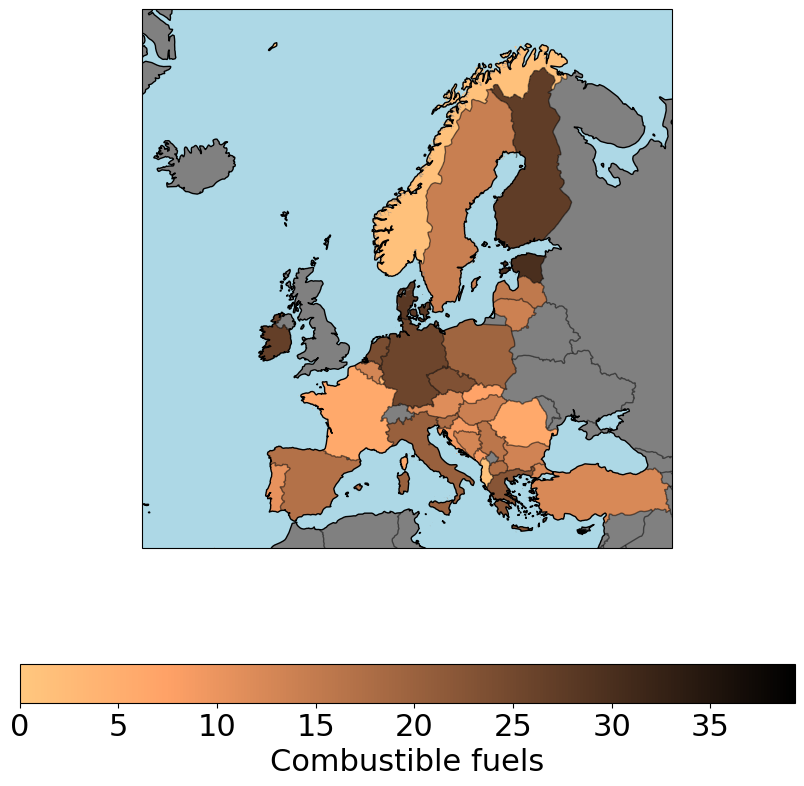

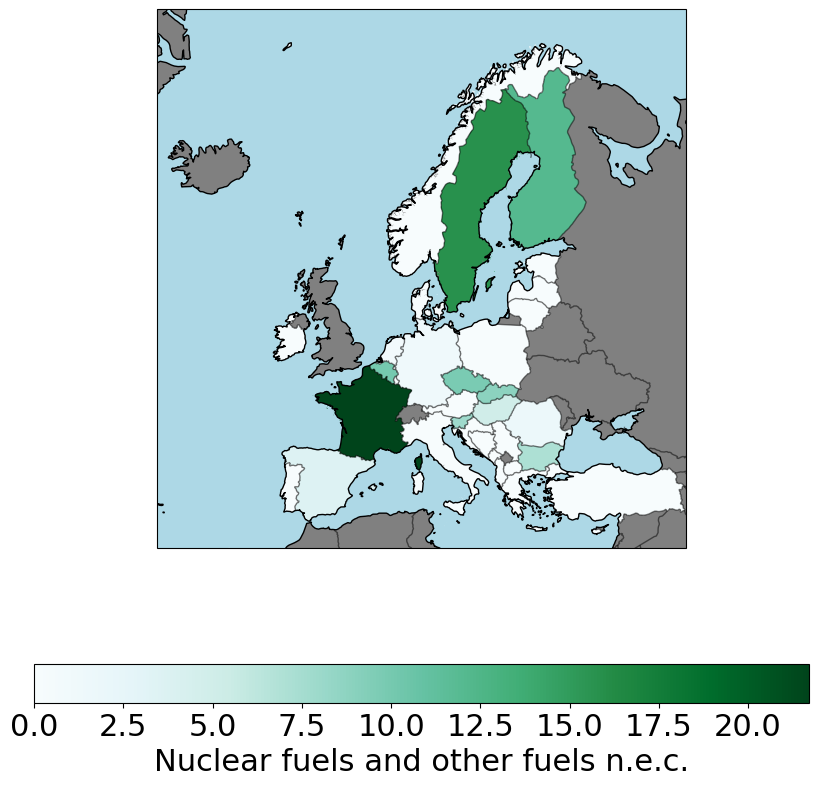

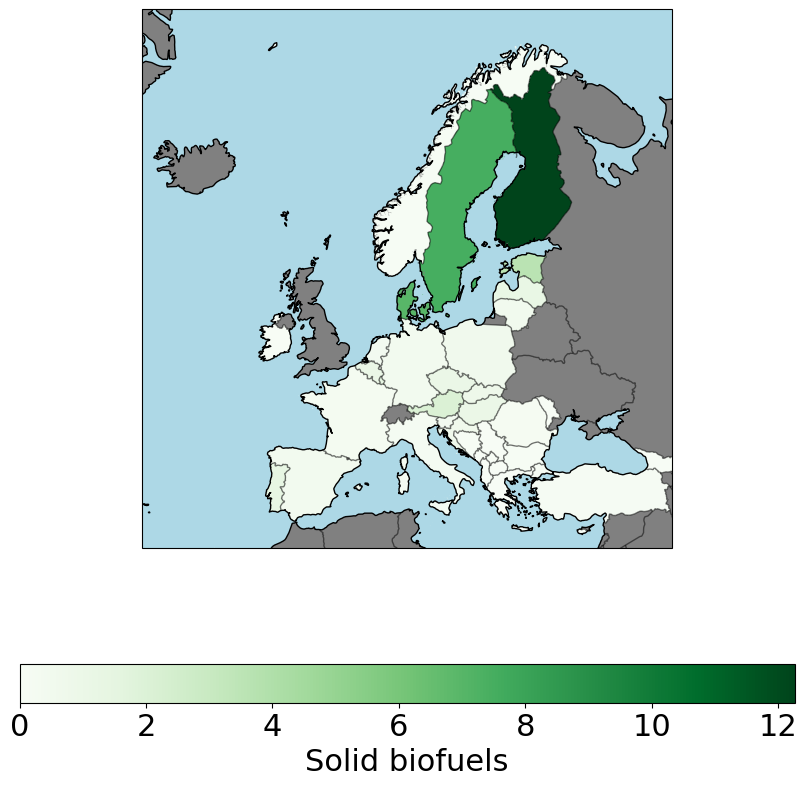

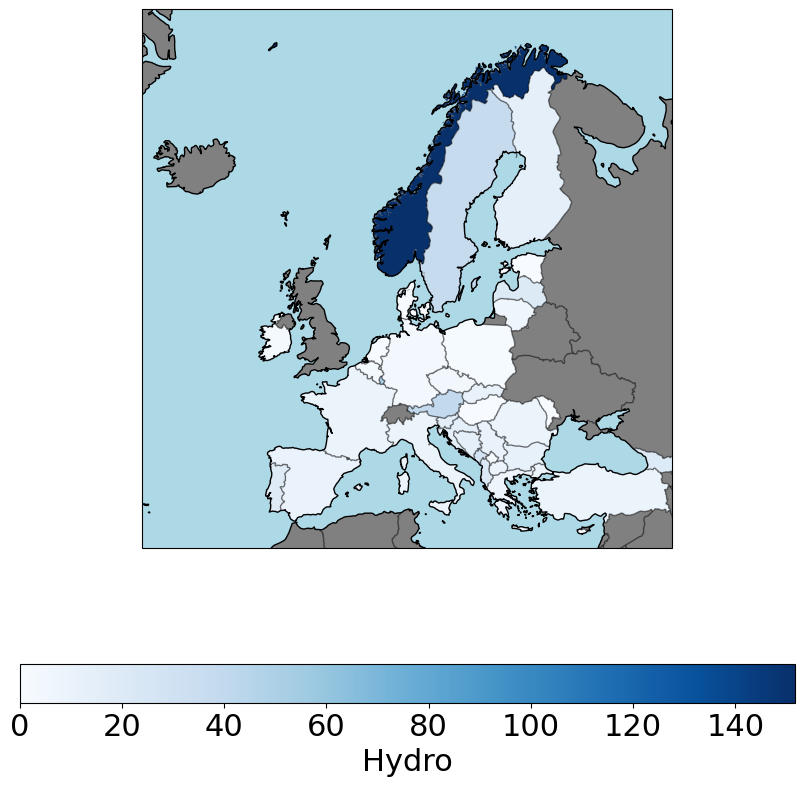

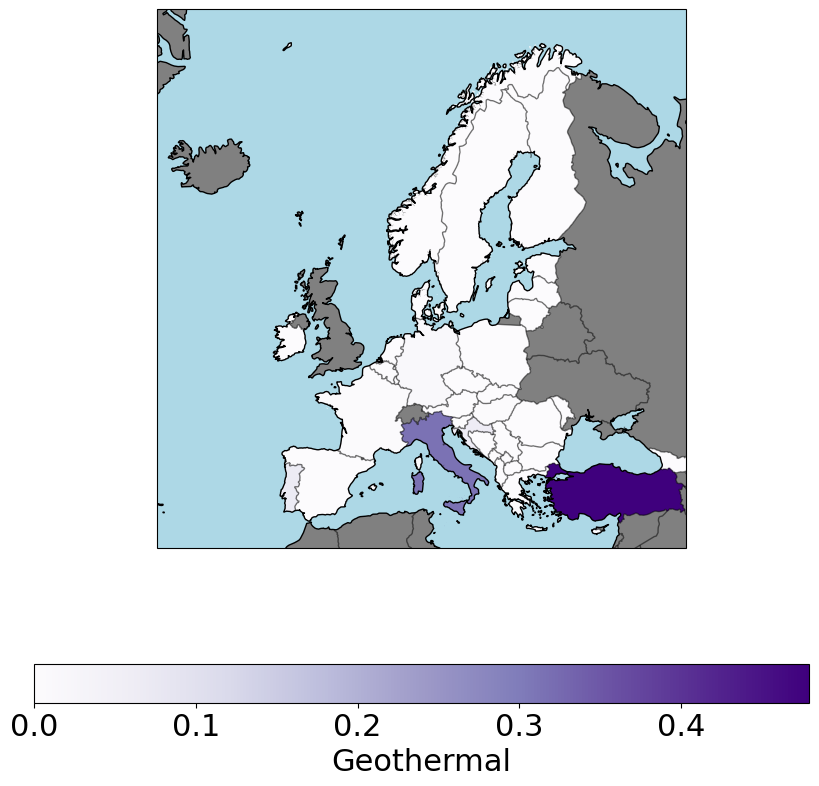

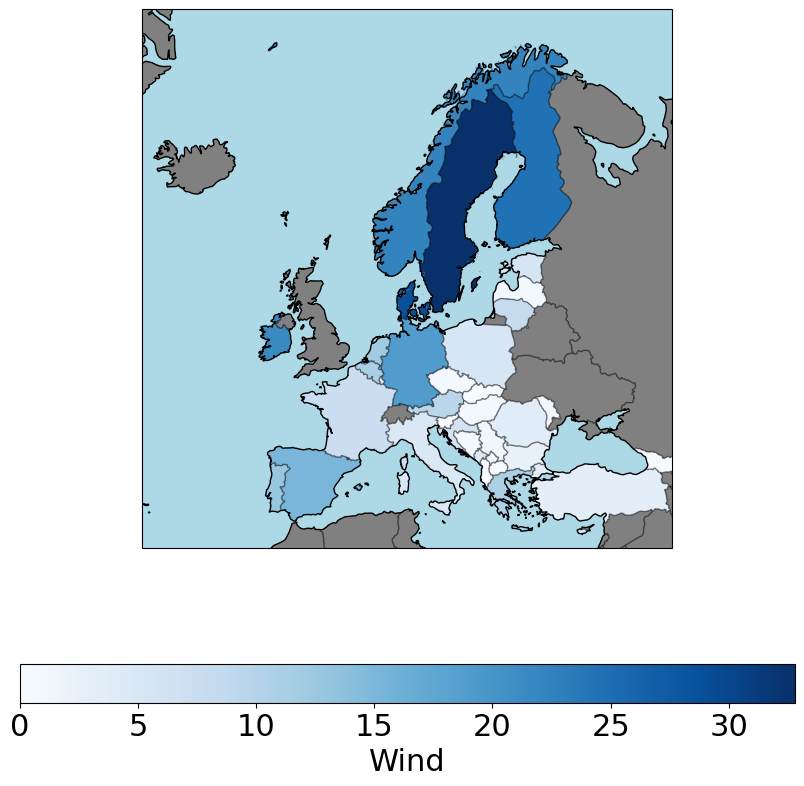

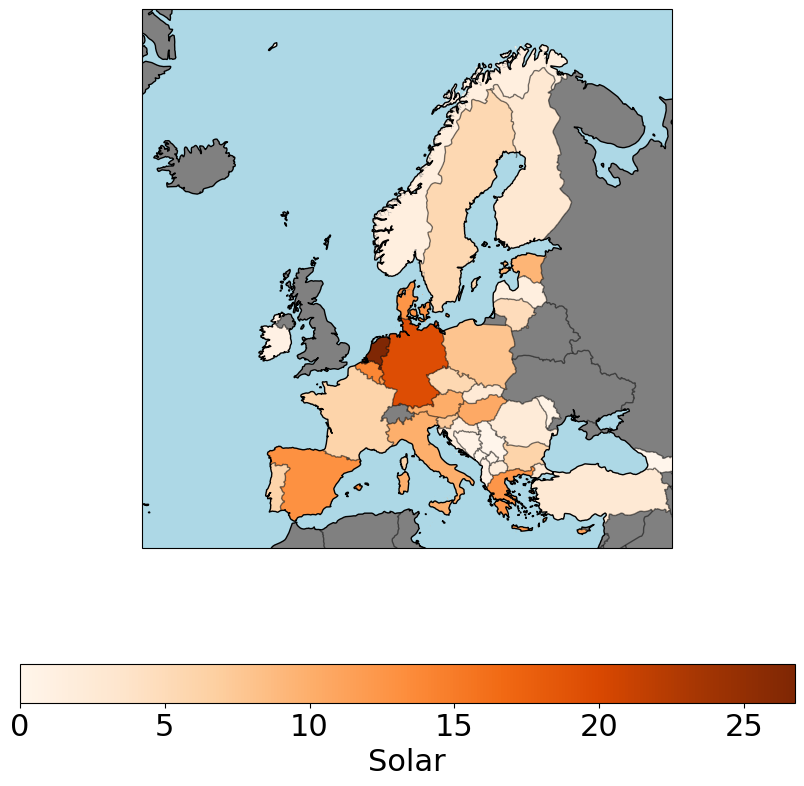

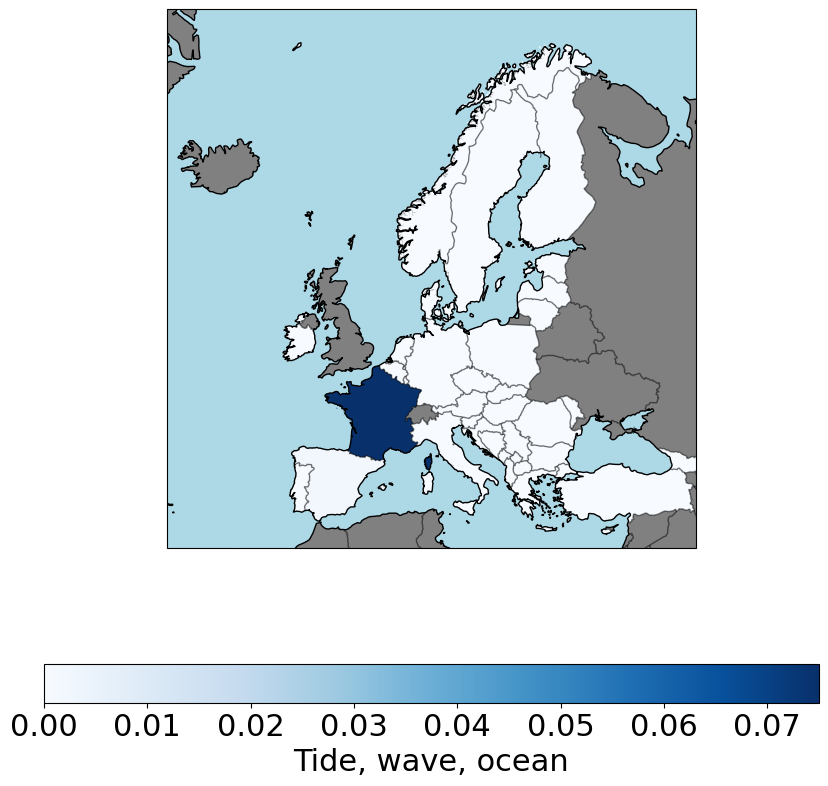

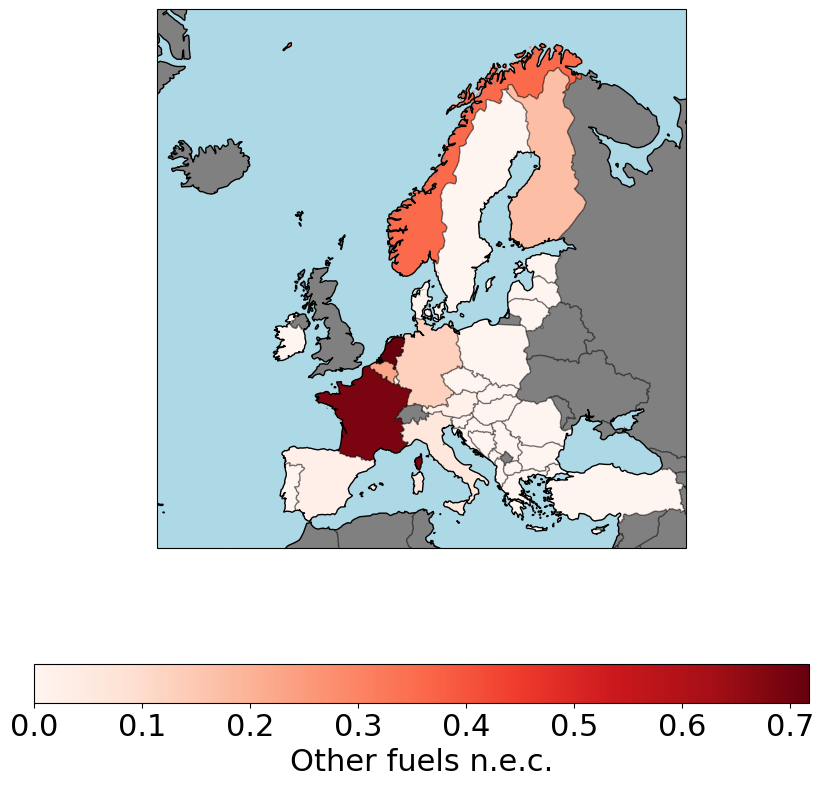

In [52]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy
from cartopy.io import shapereader
import cartopy.crs as ccrs
import geopandas

matplotlib.rcParams.update({'font.size': 22})

# get natural earth data (http://www.naturalearthdata.com/)

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'
shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shpfilename)

# Insert your lists of countries and lag times here
countries=[]
for country in data_power_production_normalized.index:
    # print(country, what_is(country, short=True))
    if country == 'RS':
        countries.append('Republic of Serbia')
        continue
    if country == 'TR':
        countries.append('Turkey')
        continue
    if country == 'XK':
        countries.append('Kosovo')
        continue
    countries.append(what_is(country, short=True))
    
# Choose your colourmap here
# https://matplotlib.org/stable/users/explain/colors/colormaps.html
    
cmap_list = [
    matplotlib.colormaps['copper_r'],   # Carbon fule
    matplotlib.colormaps['BuGn'],   # Nuclear
    matplotlib.colormaps['Greens'],   # Bofule
    matplotlib.colormaps['Blues'],   # Hydro
    matplotlib.colormaps['Purples'],   # Geotermal
    matplotlib.colormaps['Blues'],   # Wind
    matplotlib.colormaps['Oranges'],   # Solar
    matplotlib.colormaps['Blues'],   # Tide
    matplotlib.colormaps['Reds'],   # Other
] 

# Set up the canvas
for siec, i, cmap in zip(data_power_production_normalized.keys(), range(len(data_power_production_normalized.keys())), cmap_list):
    fig = plt.figure(figsize=(10, 10))
    # plt.subplot(3, 3, i+1)
    extent = [-26, 45, 33, 69] # long_min, long_max, lat_min, lat_max
    ax = plt.axes(projection=cartopy.crs.Mercator())
    ax.set_extent(extent)
    # ax.gridlines()

    # Add natural earth features and borders
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
    ax.add_feature(cartopy.feature.OCEAN, facecolor=("lightblue"))
    ax.add_feature(cartopy.feature.LAND, facecolor=('grey'))
    ax.coastlines(resolution='50m')

    power = data_power_production_normalized[siec]

    # Normalise the lag times to between 0 and 1 to extract the colour
    power_norm = (power-np.nanmin(power))/(np.nanmax(power) - np.nanmin(power))

    for country, pow_norm in zip(countries, power_norm):
        # read the borders of the country in this loop
        # print(country)
        poly = df.loc[df['ADMIN'] == country]['geometry'].values[0]
        # get the color for this country
        rgba = cmap(pow_norm)
        # plot the country on a map
        ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor=rgba, edgecolor='none', zorder=1);

    # Add a scatter plot of the original data so the colorbar has the correct numbers. Hacky but it works
    dummy_scat = ax.scatter(power, power, c=power, cmap=cmap, zorder=0)
    fig.colorbar(mappable=dummy_scat, label=what_is(siec, short=True), orientation='horizontal');
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

<!-- 4. Norveška in hidro, kaj se dogaja? -->
4. Vodna energija na Norveškem. Zakaj se je proizvaja tako veliko?

In [53]:
what_is('RA130')

'type: siec --> RA130: Pumped hydro power'

In [54]:
# data_renewables_small.iloc[row]
data_pop_Norwey = data_pop_imputed.loc[data_pop_imputed['geo'] == 'NO'].set_index('geo')
data_pop_Norwey

1990       1991       1992       1993       1994       1995  \
geo                                                                     
NO   4233116.0  4249830.0  4273634.0  4299167.0  4324815.0  4348410.0   

          1996       1997       1998       1999       2000       2001  \
geo                                                                     
NO   4369957.0  4392714.0  4417599.0  4445329.0  4478497.0  4503436.0   

          2002       2003       2004       2005       2006       2007  \
geo                                                                     
NO   4524066.0  4552252.0  4577457.0  4606363.0  4640219.0  4681134.0   

          2008       2009       2010       2011       2012       2013  \
geo                                                                     
NO   4737171.0  4799252.0  4858199.0  4920305.0  4985870.0  5051275.0   

          2014       2015       2016       2017       2018       2019  \
geo                                                                     
NO   5109056.0  5165802.0  5213985.0  5258317.0  5295619.0  5328212.0   

          2020       2021       2022  
geo                                   
NO   5367580.0  5391369.0  5425270.0

In [55]:
NO = data_renewables['geo'] == 'NO'

SIEC = data_renewables['siec'] == None
hydro = {'RA110', 'RA110ROR', 'RA120', 'RA130'} # 'RA100',

for siec in hydro:
    SIEC = np.logical_or(SIEC, data_renewables['siec'] == siec)

condition = np.logical_and(NO, SIEC)

data_hydro_Norway = data_renewables.loc[condition].drop(['freq', 'plant_tec', 'unit', 'geo'], axis=1).set_index('siec')
data_hydro_Norway

1990     1991     1992     1993     1994     1995     1996  \
siec                                                                      
RA110     25817.0  25822.0  25838.0  25801.0  26215.0  27379.0  27494.0   
RA110ROR      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
RA120      1067.0   1067.0   1067.0   1067.0   1067.0    673.0    672.0   
RA130         0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             1997     1998     1999     2000     2001     2002     2003  \
siec                                                                      
RA110     27327.0  26978.0  27215.0  26766.0  26319.0  26604.0  26947.0   
RA110ROR      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
RA120       672.0    663.0    663.0   1360.0   1360.0   1309.0   1042.0   
RA130         0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             2004     2005     2006     2007     2008     2009     2010  \
siec                                                                      
RA110     26721.0  27222.0  27398.0  27647.0  28062.0  28188.0  28367.0   
RA110ROR      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
RA120      1309.0   1327.0   1327.0   1310.0   1351.0   1351.0   1326.0   
RA130         0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             2011     2012     2013     2014     2015     2016     2017  \
siec                                                                      
RA110     28618.0  29158.0  29682.0  29889.0  29939.0  30281.0  30382.0   
RA110ROR      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
RA120      1351.0   1351.0   1351.0   1351.0   1433.0   1536.0   1530.0   
RA130         0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             2018     2019     2020     2021     2022  
siec                                                   
RA110     31120.0  31387.0  32285.3  32628.3  32822.3  
RA110ROR      0.0      0.0      0.0      0.0      0.0  
RA120      1410.0   1410.0   1446.7   1446.7   1446.7  
RA130         0.0      0.0      0.0      0.0      0.0

In [56]:
for row in range(len(data_hydro_Norway)):
    data_hydro_Norway.iloc[row] = data_hydro_Norway.iloc[row] * 24 * 1000 / data_pop_Norwey.iloc[0]
data_hydro_Norway

1990        1991        1992        1993        1994  \
siec                                                                   
RA110     146.371609  145.824186  145.101803  144.033484  145.476743   
RA110ROR    0.000000    0.000000    0.000000    0.000000    0.000000   
RA120       6.049444    6.025653    5.992090    5.956503    5.921178   
RA130       0.000000    0.000000    0.000000    0.000000    0.000000   

                1995        1996        1997        1998        1999  \
siec                                                                   
RA110     151.111786  150.998282  149.303597  146.566495  146.931757   
RA110ROR    0.000000    0.000000    0.000000    0.000000    0.000000   
RA120       3.714461    3.690654    3.671534    3.601957    3.579488   
RA130       0.000000    0.000000    0.000000    0.000000    0.000000   

                2000        2001        2002        2003        2004  \
siec                                                                   
RA110     143.437408  140.260903  141.133220  142.067706  140.100497   
RA110ROR    0.000000    0.000000    0.000000    0.000000    0.000000   
RA120       7.288159    7.247799    6.944196    5.493545    6.863199   
RA130       0.000000    0.000000    0.000000    0.000000    0.000000   

                2005        2006        2007        2008        2009  \
siec                                                                   
RA110     141.831636  141.707105  141.745141  142.170929  140.961967   
RA110ROR    0.000000    0.000000    0.000000    0.000000    0.000000   
RA120       6.913915    6.863469    6.716321    6.844591    6.756053   
RA130       0.000000    0.000000    0.000000    0.000000    0.000000   

                2010        2011        2012        2013        2014  \
siec                                                                   
RA110     140.135882  139.591346  140.355043  141.027364  140.404803   
RA110ROR    0.000000    0.000000    0.000000    0.000000    0.000000   
RA120       6.550576    6.589835    6.503178    6.418973    6.346378   
RA130       0.000000    0.000000    0.000000    0.000000    0.000000   

                2015        2016        2017        2018        2019  \
siec                                                                   
RA110     139.094762  139.383600  138.669464  141.037337  141.377258   
RA110ROR    0.000000    0.000000    0.000000    0.000000    0.000000   
RA120       6.657630    7.070216    6.983223    6.390188    6.351099   
RA130       0.000000    0.000000    0.000000    0.000000    0.000000   

                2020        2021        2022  
siec                                          
RA110     144.356898  145.246819  145.197419  
RA110ROR    0.000000    0.000000    0.000000  
RA120       6.468613    6.440071    6.399829  
RA130       0.000000    0.000000    0.000000

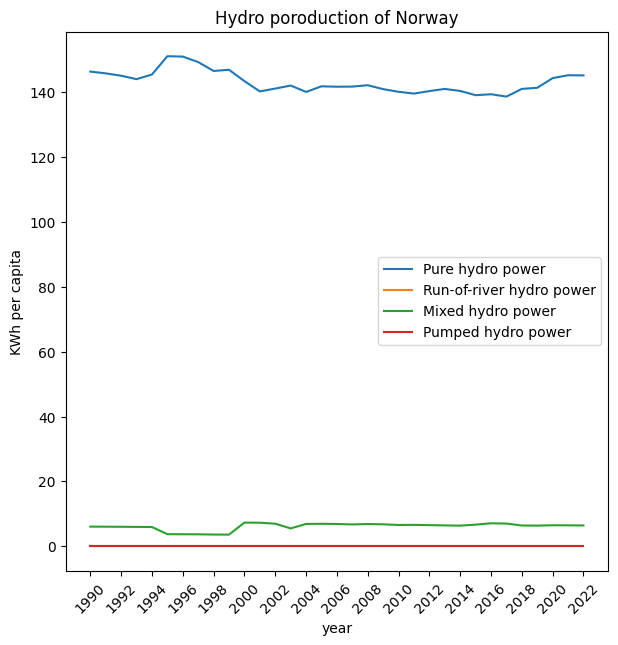

In [57]:

plt.figure(figsize=(7, 7))
plt.title("Hydro poroduction of Norway")

for power, siec in zip(data_hydro_Norway.values, data_hydro_Norway.index):
    plt.plot(data_hydro_Norway.keys(), power, label=what_is(siec, short=True))
    plt.xlabel("year")
    plt.ylabel("KWh per capita")
    plt.legend()
    plt.xticks(data_hydro_Norway.keys()[::2], rotation=45)
plt.show()

Norveška dobro izkorišča svoje vodne vire, večina elektrarn je postavljenih na že obstoječih jezerih in posledično ni potrebno dodatne gradnje ali množičnega preseljevanja prebivalstva. Vodno energijo je lahko uravnavati in proizvajati glede na potrebo. Prav tako hidroelektrarne na Norveškem ležijo na višji nadmorski višini, kar je posledica površja države, in posledično proizvajajo manj emisij. Razlog tiči za tem, da je v goratih predelih manj vegetacije in je na splošno bolj mrzlo, kar posledično vpliva na zmanjšano proizvodnjo metana v hidroelektrarnah kot stranski proizvod.

Vir: https://businessnorway.com/articles/how-norway-produces-hydropower-with-a-minimal-carbon-footprint

In [58]:
soalr = [
'RA420',
# 'RA420KW20-1000', 
'RA420KW30-1000', 
# 'RA420KW30-1000_OG', 
'RA420KW30-1000_RT', 
# 'RA420KW_LT10', 
# 'RA420KW_LT20', 
'RA420KW_LT30', 
# 'RA420KW_LT30_OG', 
'RA420KW_LT30_RT', 
'RA420MW_GT1',
# 'RA420MW_GT1_OG', 
'RA420MW_GT1_RT', 
# 'RA420OG',
]

In [59]:
for siec in soalr:
    print(what_is(siec))

type: siec --> RA420: Solar photovoltaic
type: siec --> RA420KW30-1000: Solar photovoltaic (30 kW - 1000 kW)
type: siec --> RA420KW30-1000_RT: Solar photovoltaic (30 kW - 1000 kW, roof top)
type: siec --> RA420KW_LT30: Solar photovoltaic (< 30 kW)
type: siec --> RA420KW_LT30_RT: Solar photovoltaic (< 30 kW, roof top)
type: siec --> RA420MW_GT1: Solar photovoltaic (1+ MW)
type: siec --> RA420MW_GT1_RT: Solar photovoltaic (1+ MW, roof top)


In [60]:
GEO = data_renewables['geo'] == 'SI'

PLANT_TEC = data_renewables['plant_tec'] ==  'CAP_NET_ELC' 

SIEC = data_renewables['siec'] == None

for siec in soalr:
    SIEC = np.logical_or(SIEC, data_renewables['siec'] == siec)
    
condition = np.logical_and(GEO, SIEC)
condition = np.logical_and(condition , PLANT_TEC)

data_renewables.loc[condition].drop(['freq', 'plant_tec', 'unit'], axis=1)

siec geo  1990  1991  1992  1993  1994  1995  1996  1997  \
725               RA420  SI   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
884      RA420KW30-1000  SI   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1124  RA420KW30-1000_RT  SI   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1404       RA420KW_LT30  SI   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1644    RA420KW_LT30_RT  SI   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1765        RA420MW_GT1  SI   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2007     RA420MW_GT1_RT  SI   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

      1998  1999  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  \
725    0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   4.0   
884    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1124   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1404   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1644   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1765   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2007   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

      2010  2011   2012   2013   2014   2015   2016   2017   2018     2019  \
725   12.0  57.0  142.0  187.0  223.0  238.0  233.0  246.8  246.8  277.877   
884    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      NaN   
1124   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      NaN   
1404   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      NaN   
1644   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      NaN   
1765   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000   
2007   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      NaN   

        2020     2021     2022  
725   369.78  461.164  626.164  
884      NaN      NaN  262.779  
1124     NaN      NaN  249.640  
1404     NaN      NaN  357.665  
1644     NaN      NaN  357.665  
1765    0.00    0.000    5.720  
2007     NaN      NaN    0.000